<h1><center>EE69210: Machine Learning for Signal Processing Laboratory</center></h1>
<h2><center>Experiment-4: Decision Trees and Random Forests</center></h2>
<h3><center>Anirvan Krishna | 21EE38002</center></h3>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import networkx as nx

## Classifier Models

### Decision Tree Classifier

In [6]:
class Node:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.split_feature = None
        self.split_threshold = None
        self.left = None
        self.right = None
        self.is_leaf = False
        self.info_gain = 0
        self.probability = None

    def is_pure(self):
        return len(np.unique(self.Y)) == 1

    def majority_class(self):
        values, counts = np.unique(self.Y, return_counts=True)
        return values[np.argmax(counts)]

def data_entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Prevent log(0)

def decision_node(X, Y):
    best_info_gain = -np.inf
    best_feature = None
    best_threshold = None
    best_left, best_right = None, None
    original_entropy = data_entropy(Y)

    for feature in range(X.shape[0]):  # Iterate over features
        thresholds = np.unique(X[feature, :])
        for threshold in thresholds:
            left_mask = X[feature, :] < threshold
            right_mask = ~left_mask

            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue  # Avoid empty splits

            left_entropy = data_entropy(Y[left_mask])
            right_entropy = data_entropy(Y[right_mask])
            split_entropy = (left_mask.sum() / len(Y)) * left_entropy + (right_mask.sum() / len(Y)) * right_entropy
            info_gain = original_entropy - split_entropy

            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = feature
                best_threshold = threshold
                best_left = (X[:, left_mask], Y[left_mask])
                best_right = (X[:, right_mask], Y[right_mask])
    
    return best_left, best_right, best_feature, best_threshold, best_info_gain

def build_tree(X, Y, min_samples_split=2, min_info_gain=1e-4):
    node = Node(X, Y)
    node_entropy = data_entropy(Y)
    node.probability = {int(cls): np.sum(Y == cls) / len(Y) for cls in np.unique(Y)}

    if node.is_pure() or len(Y) < min_samples_split:
        node.is_leaf = True
        return node

    left_data, right_data, feature, threshold, info_gain = decision_node(X, Y)
    
    if info_gain < min_info_gain:
        node.is_leaf = True
        return node
    
    node.split_feature = feature
    node.split_threshold = threshold
    node.info_gain = info_gain
    node.left = build_tree(left_data[0], left_data[1], min_samples_split, min_info_gain)
    node.right = build_tree(right_data[0], right_data[1], min_samples_split, min_info_gain)
    return node

def predict(node, X):
    if node.is_leaf:
        return node.majority_class()
    if X[node.split_feature] < node.split_threshold:
        return predict(node.left, X)
    else:
        return predict(node.right, X)

def visualize_tree(node, depth=0):
    indent = "  " * depth
    if node.is_leaf:
        print(f"{indent}Leaf: Probabilities {node.probability}")
    else:
        print(f"{indent}Node: Feature {node.split_feature}, Threshold {node.split_threshold:.2f}, Info Gain {node.info_gain:.4f}")
        visualize_tree(node.left, depth + 1)
        visualize_tree(node.right, depth + 1)

In [7]:
class RandomForest:
    def __init__(self, num_trees=10, min_samples_split=4, min_info_gain=1e-4):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.min_info_gain = min_info_gain
        self.trees = []

    def fit(self, X, Y):
        for _ in range(self.num_trees):
            indices = np.random.choice(X.shape[1], int(X.shape[1]/3), replace=True)
            self.trees.append(build_tree(X[:, indices], Y[indices], 
                            self.min_samples_split, self.min_info_gain))
        return self
        
    def predict(self, x):
        predictions = []
        for tree in self.trees:
            predictions.append(predict(tree, x))
        predictions = np.array(predictions)
        return np.argmax(np.bincount(predictions.astype(int)))

In [23]:
def plot_decision_tree(root):
    # Create a directed graph
    G = nx.DiGraph()
    pos = {}
    labels = {}
    node_colors = []
    node_shapes = []
    
    # BFS to build the graph and assign positions
    queue = [(root, 0, 0, 0)]  # node, level, x_pos, node_id
    node_id = 0
    min_x = 0
    max_x = 0
    
    while queue:
        node, level, x_pos, current_id = queue.pop(0)
        
        # Add node to graph
        G.add_node(current_id)
        pos[current_id] = (x_pos, -level)  # Negative level to plot top-to-bottom
        min_x = min(min_x, x_pos)
        max_x = max(max_x, x_pos)
        
        # Set node attributes
        if node.is_leaf:
            labels[current_id] = f"Class: {node.majority_class()}"
            node_colors.append('lightblue')
            node_shapes.append('s')  # square for leaf nodes
        else:
            labels[current_id] = f"Feature: {node.split_feature}\nGain: {node.info_gain:.4f}"
            node_colors.append('lightgreen')
            node_shapes.append('o')  # circle for split nodes
            
            # Add children to queue
            node_id += 1
            left_id = node_id
            G.add_edge(current_id, left_id)
            queue.append((node.left, level + 1, x_pos - 1/(2**level), left_id))
            
            node_id += 1
            right_id = node_id
            G.add_edge(current_id, right_id)
            queue.append((node.right, level + 1, x_pos + 1/(2**level), right_id))
    
    
    # Draw nodes
    for shape in set(node_shapes):
        # Get indices of nodes with current shape
        node_idx = [i for i, s in enumerate(node_shapes) if s == shape]
        nx.draw_networkx_nodes(G, pos, 
                             nodelist=[list(G.nodes())[i] for i in node_idx],
                             node_color=[node_colors[i] for i in node_idx],
                             node_shape=shape, 
                             node_size=3000)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title("Decision Tree Visualization")
    plt.axis('off')
    plt.show()

## XOR Dataset

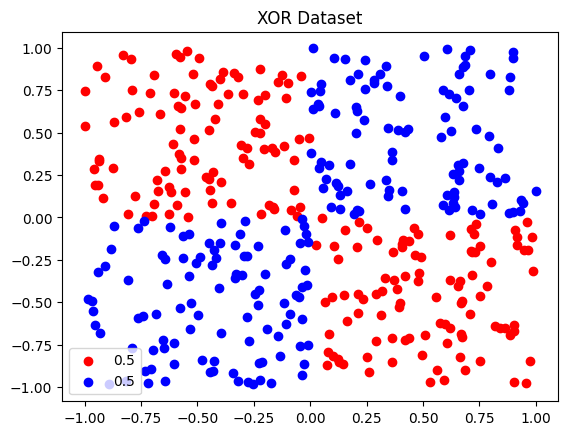

In [9]:
x1 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
y1 = np.concatenate ([np.random.uniform(-1, 0, 100), np.random.uniform(0, 1,100)])
label1 = np.zeros_like(x1) # create a list of zeros of the same shape as x1 and y1

x2 = np.concatenate ([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0,100)])
y2 = np.concatenate ([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0,
                                                                      100)])
label2 = np.ones_like(x2) # create a list of ones of the same shape as x2 and y2

X = np.concatenate([np.vstack([x1 , y1]), np.vstack([x2 , y2])], axis =1).T
y = np.concatenate([np.vstack(label1), np.vstack(label2)])

plt.scatter(x1 , y1 , c='red', label='Class 1')
plt.scatter(x2 , y2 , c='blue', label='Class 2')
plt.legend((0.5, 0.5))
plt.title('XOR Dataset')
plt.show()

In [10]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (400, 2)
y Shape: (400, 1)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (280, 2)
X_test Shape: (120, 2)
y_train Shape: (280, 1)
y_test Shape: (120, 1)


In [12]:
tree = build_tree(X_train.T, y_train, min_samples_split=4, min_info_gain=1e-4)

In [13]:
visualize_tree(tree)

Node: Feature 1, Threshold 0.98, Info Gain 0.0141
  Node: Feature 1, Threshold -0.90, Info Gain 0.0133
    Node: Feature 0, Threshold 0.26, Info Gain 0.7496
      Leaf: Probabilities {1: 1.0}
      Leaf: Probabilities {0: 1.0}
    Node: Feature 0, Threshold -0.05, Info Gain 0.0142
      Node: Feature 1, Threshold 0.00, Info Gain 0.9764
        Leaf: Probabilities {1: 1.0}
        Leaf: Probabilities {0: 1.0}
      Node: Feature 1, Threshold -0.05, Info Gain 0.5894
        Node: Feature 0, Threshold 0.07, Info Gain 0.5586
          Leaf: Probabilities {1: 1.0}
          Leaf: Probabilities {0: 1.0}
        Node: Feature 0, Threshold 0.00, Info Gain 0.1842
          Node: Feature 1, Threshold 0.06, Info Gain 0.9710
            Leaf: Probabilities {1: 1.0}
            Leaf: Probabilities {0: 1.0}
          Leaf: Probabilities {1: 1.0}
  Leaf: Probabilities {1: 1.0}


Train Accuracy:  1.000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       138
         1.0       1.00      1.00      1.00       142

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



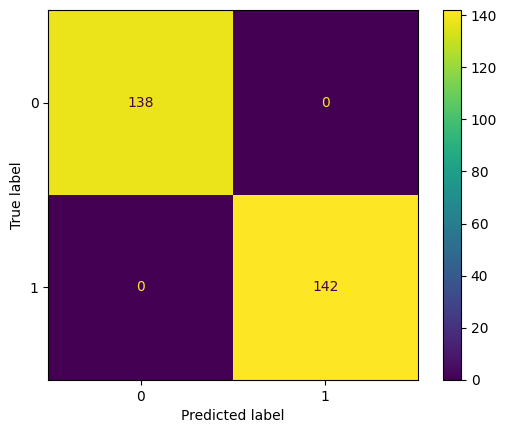

In [14]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(predict(tree, x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.950
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        62
         1.0       0.91      1.00      0.95        58

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120



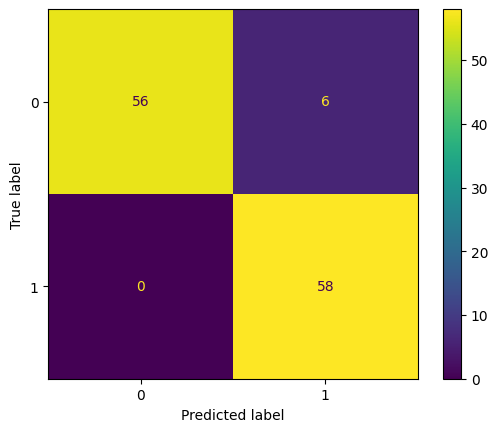

In [15]:
y_pred = []

for x in X_test:
    y_pred.append(predict(tree, x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

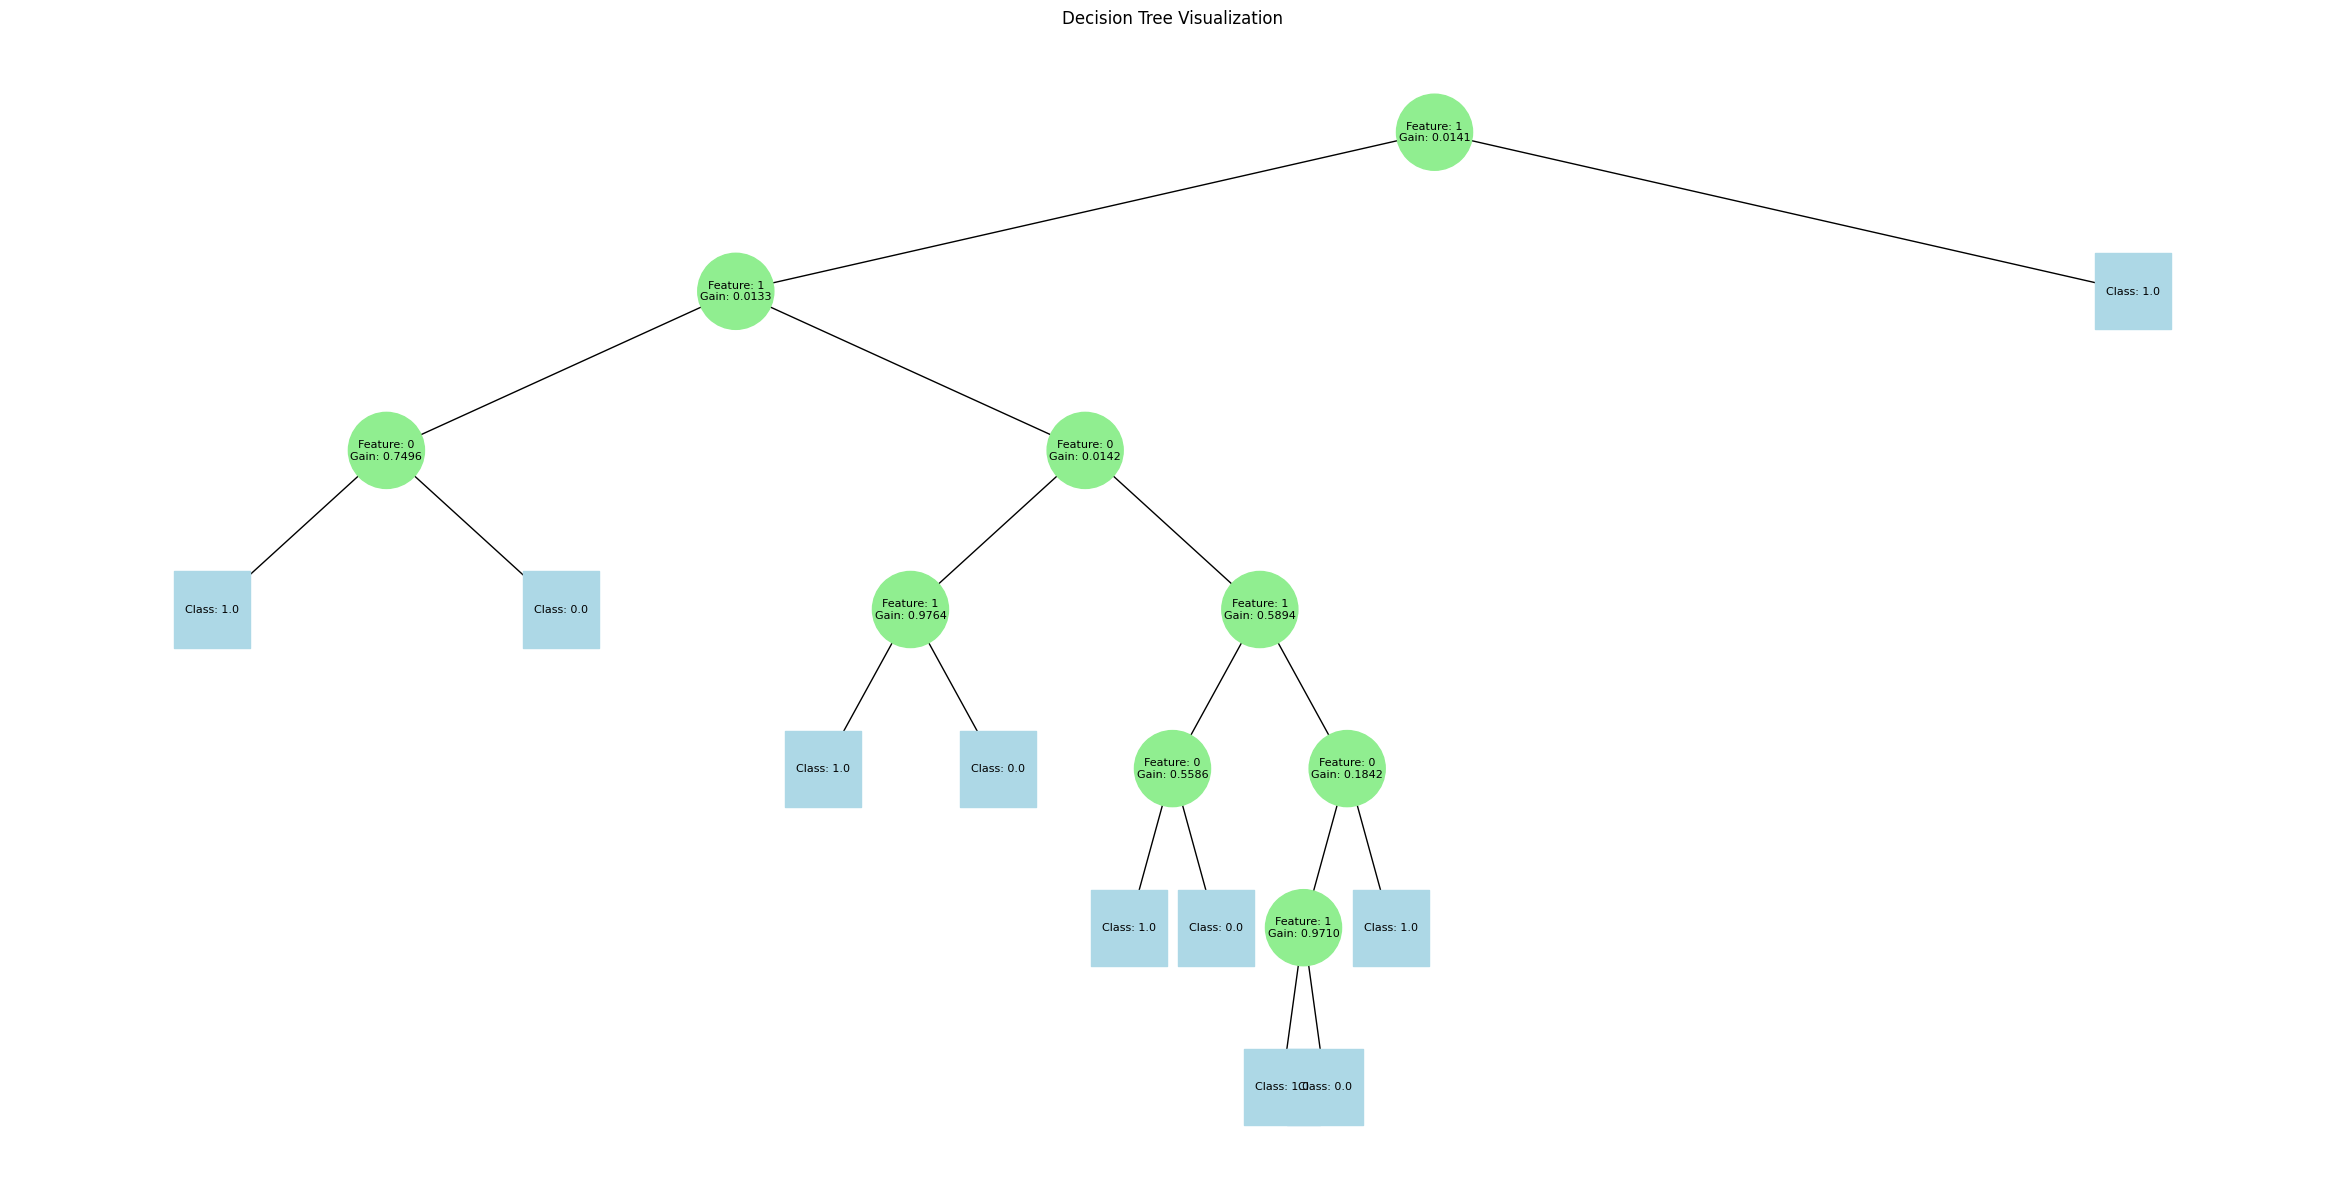

In [32]:
plt.figure(figsize=(30, 15))
plot_decision_tree(tree)

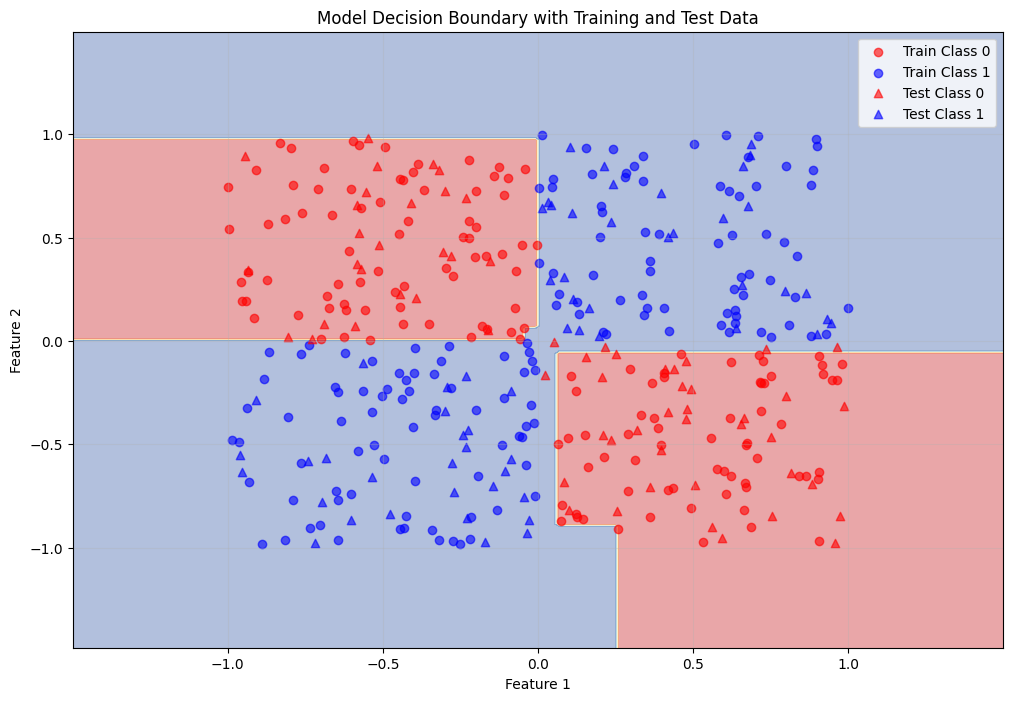

In [16]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(predict(tree, [xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Plot training data
plt.scatter(X_train[y_train[:, 0] == 0, 0], X_train[y_train[:, 0] == 0, 1],
            c='red', marker='o', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train[:, 0] == 1, 0], X_train[y_train[:, 0] == 1, 1],
            c='blue', marker='o', label='Train Class 1', alpha=0.6)

# Plot testing data
plt.scatter(X_test[y_test[:, 0] == 0, 0], X_test[y_test[:, 0] == 0, 1],
            c='red', marker='^', label='Test Class 0', alpha=0.6)
plt.scatter(X_test[y_test[:, 0] == 1, 0], X_test[y_test[:, 0] == 1, 1],
            c='blue', marker='^', label='Test Class 1', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
forest = RandomForest()
forest.fit(X_train.T, y_train)

Train Accuracy:  0.982
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       138
         1.0       0.99      0.98      0.98       142

    accuracy                           0.98       280
   macro avg       0.98      0.98      0.98       280
weighted avg       0.98      0.98      0.98       280



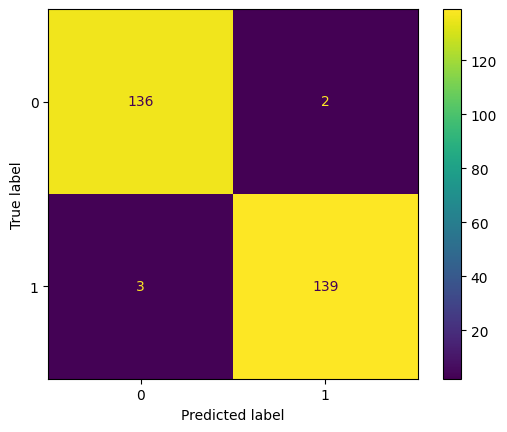

In [18]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(forest.predict(x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.967
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97        62
         1.0       0.95      0.98      0.97        58

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



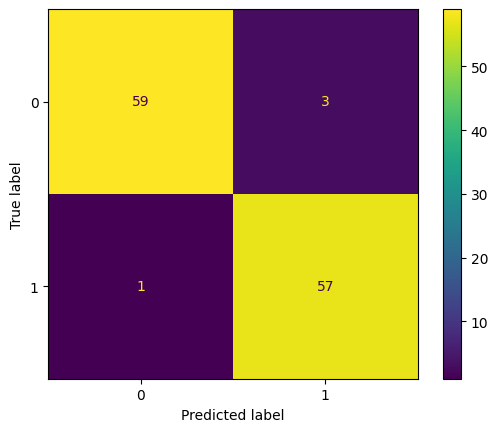

In [19]:
y_pred = []

for x in X_test:
    y_pred.append(forest.predict(x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

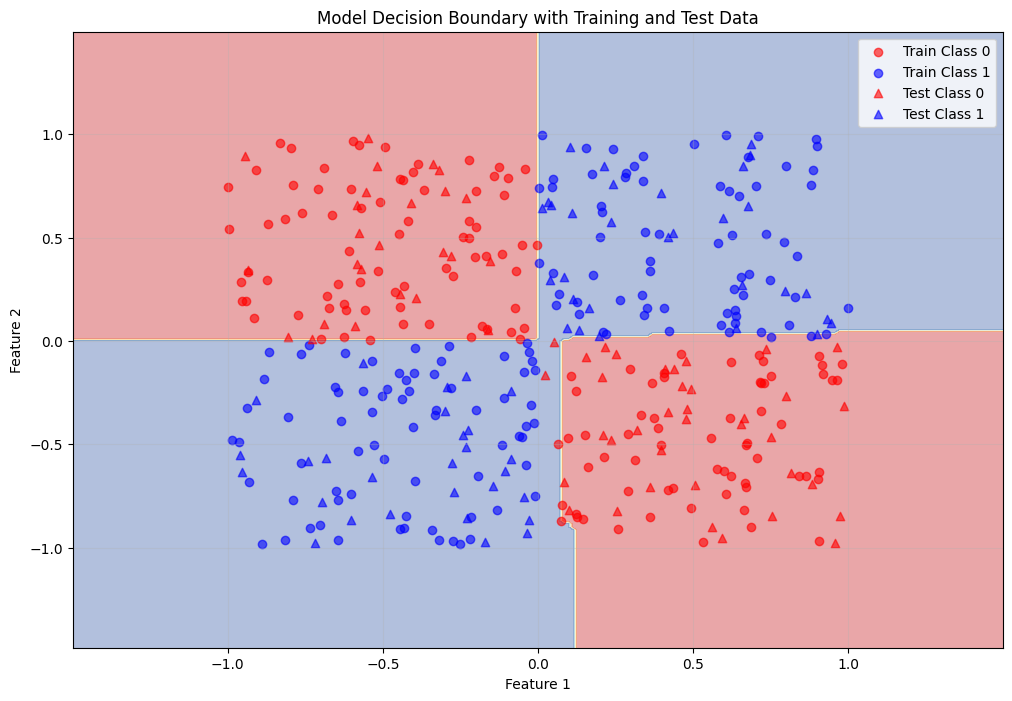

In [20]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(forest.predict([xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Plot training data
plt.scatter(X_train[y_train[:, 0] == 0, 0], X_train[y_train[:, 0] == 0, 1],
            c='red', marker='o', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train[:, 0] == 1, 0], X_train[y_train[:, 0] == 1, 1],
            c='blue', marker='o', label='Train Class 1', alpha=0.6)

# Plot testing data
plt.scatter(X_test[y_test[:, 0] == 0, 0], X_test[y_test[:, 0] == 0, 1],
            c='red', marker='^', label='Test Class 0', alpha=0.6)
plt.scatter(X_test[y_test[:, 0] == 1, 0], X_test[y_test[:, 0] == 1, 1],
            c='blue', marker='^', label='Test Class 1', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Concentric Circles Dataset

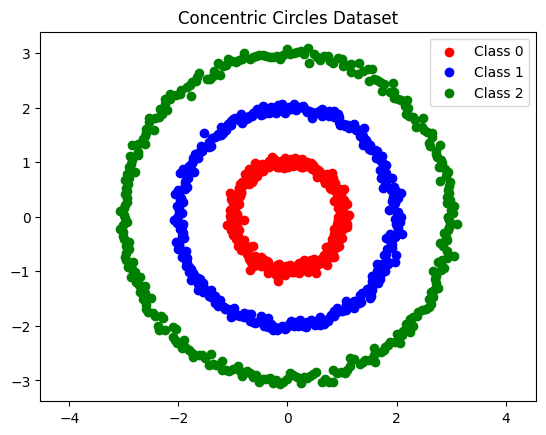

In [33]:
# Set the number of samples and noise level
n = 300
noise = 0.06

# Generate the data
theta = np.linspace(0, 2*np.pi, n)
r1 = np.random.normal(0, noise, n) + 1
r2 = np.random.normal(0, noise, n) + 2
r3 = np.random.normal(0, noise, n) + 3

x1 = r1*np.cos(theta)
y1 = r1*np.sin(theta)

x2 = r2*np.cos(theta)
y2 = r2*np.sin(theta)

x3 = r3*np.cos(theta)
y3 = r3*np.sin(theta)

# Concatenate the data and labels
X = np.concatenate([np.vstack([x1, y1]), np.vstack([x2, y2]), np.vstack([x3, y3])], axis=1)
y = np.concatenate([np.zeros(n), np.ones(n), np.full(n, 2)])

# Plot the data with different colors for each class
plt.scatter(x1, y1, c='red', label='Class 0')
plt.scatter(x2, y2, c='blue', label='Class 1')
plt.scatter(x3, y3, c='green', label='Class 2')
plt.legend()
plt.axis('equal')
plt.title('Concentric Circles Dataset')
plt.show()

In [34]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (2, 900)
y Shape: (900,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X.T, y, 
                                                    test_size=0.3, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (630, 2)
X_test Shape: (270, 2)
y_train Shape: (630,)
y_test Shape: (270,)


In [36]:
tree = build_tree(X_train.T, y_train, min_samples_split=4, min_info_gain=1e-4)

In [37]:
visualize_tree(tree)

Node: Feature 0, Threshold 1.14, Info Gain 0.1731
  Node: Feature 0, Threshold -1.10, Info Gain 0.3495
    Node: Feature 0, Threshold -2.05, Info Gain 0.4199
      Leaf: Probabilities {2: 1.0}
      Node: Feature 1, Threshold 2.21, Info Gain 0.3295
        Node: Feature 1, Threshold -1.69, Info Gain 0.7052
          Leaf: Probabilities {2: 1.0}
          Leaf: Probabilities {1: 1.0}
        Leaf: Probabilities {2: 1.0}
    Node: Feature 1, Threshold 1.67, Info Gain 0.3396
      Node: Feature 1, Threshold -1.17, Info Gain 0.7377
        Node: Feature 1, Threshold -2.07, Info Gain 0.9730
          Leaf: Probabilities {2: 1.0}
          Leaf: Probabilities {1: 1.0}
        Leaf: Probabilities {0: 1.0}
      Node: Feature 1, Threshold 2.81, Info Gain 0.9779
        Leaf: Probabilities {1: 1.0}
        Leaf: Probabilities {2: 1.0}
  Node: Feature 0, Threshold 2.11, Info Gain 0.4374
    Node: Feature 1, Threshold -1.68, Info Gain 0.3147
      Leaf: Probabilities {2: 1.0}
      Node: Feature 

Train Accuracy:  1.000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       217
         1.0       1.00      1.00      1.00       189
         2.0       1.00      1.00      1.00       224

    accuracy                           1.00       630
   macro avg       1.00      1.00      1.00       630
weighted avg       1.00      1.00      1.00       630



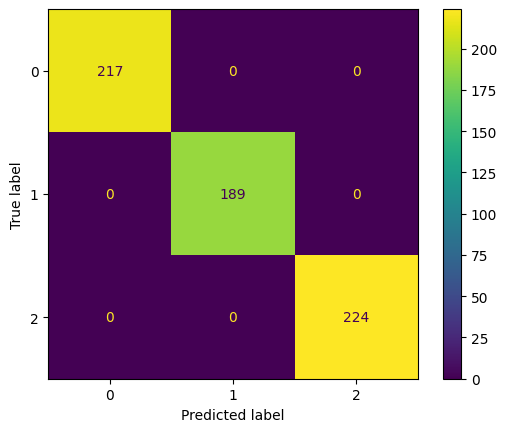

In [38]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(predict(tree, x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.974
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        83
         1.0       0.97      0.96      0.97       111
         2.0       0.96      0.96      0.96        76

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg       0.97      0.97      0.97       270



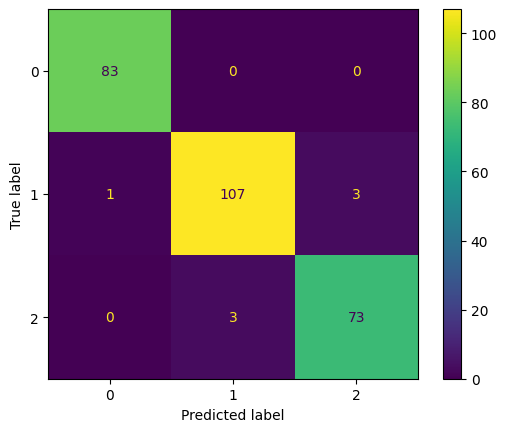

In [39]:
y_pred = []

for x in X_test:
    y_pred.append(predict(tree, x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

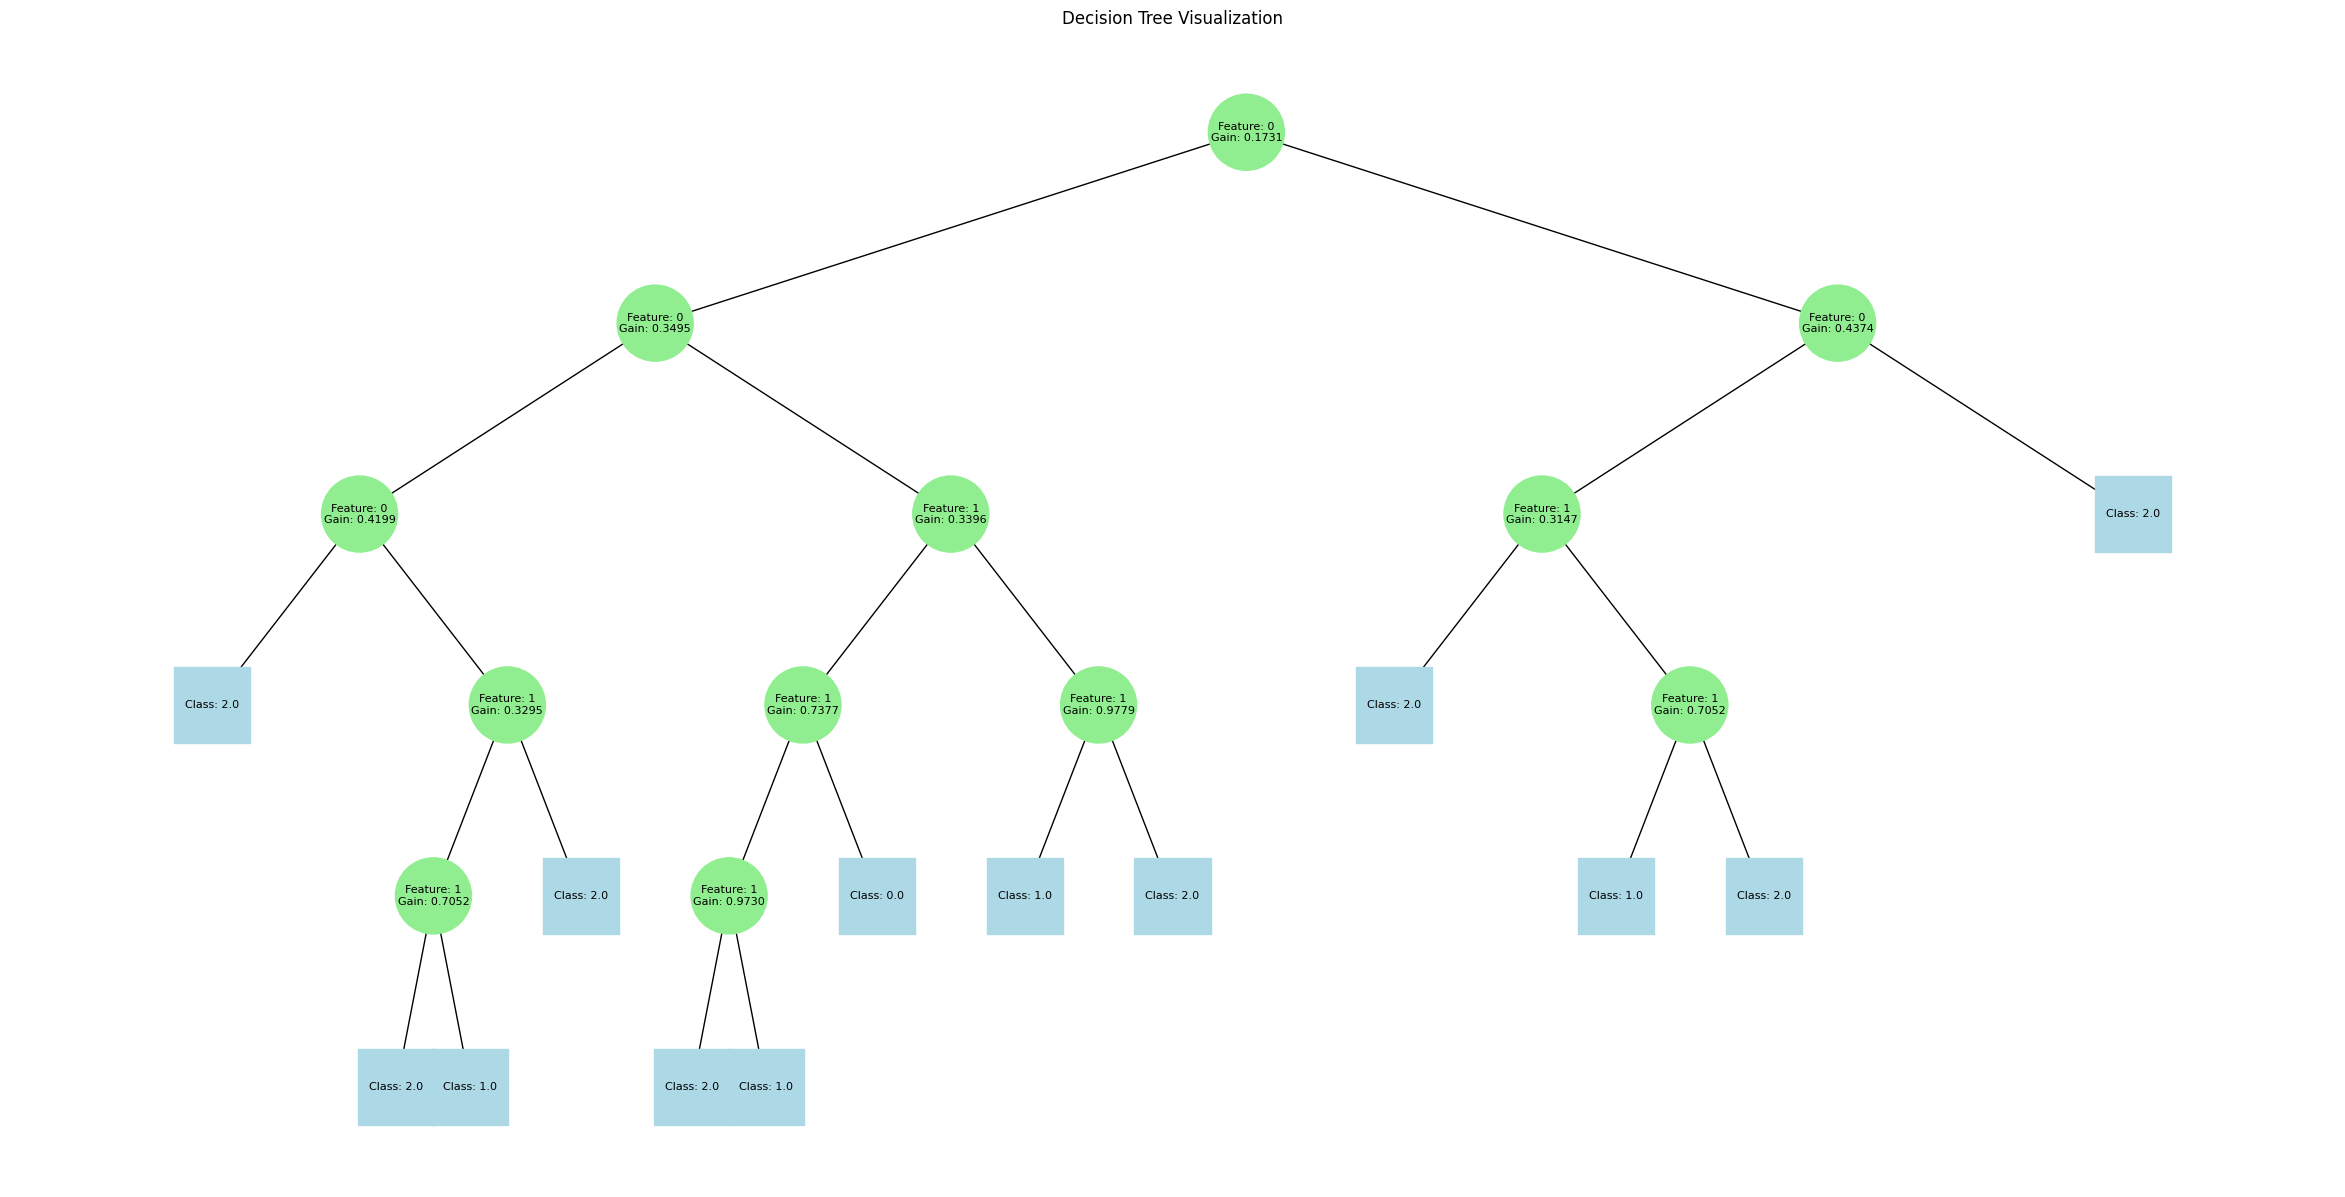

In [40]:
plt.figure(figsize=(30, 15))
plot_decision_tree(tree)

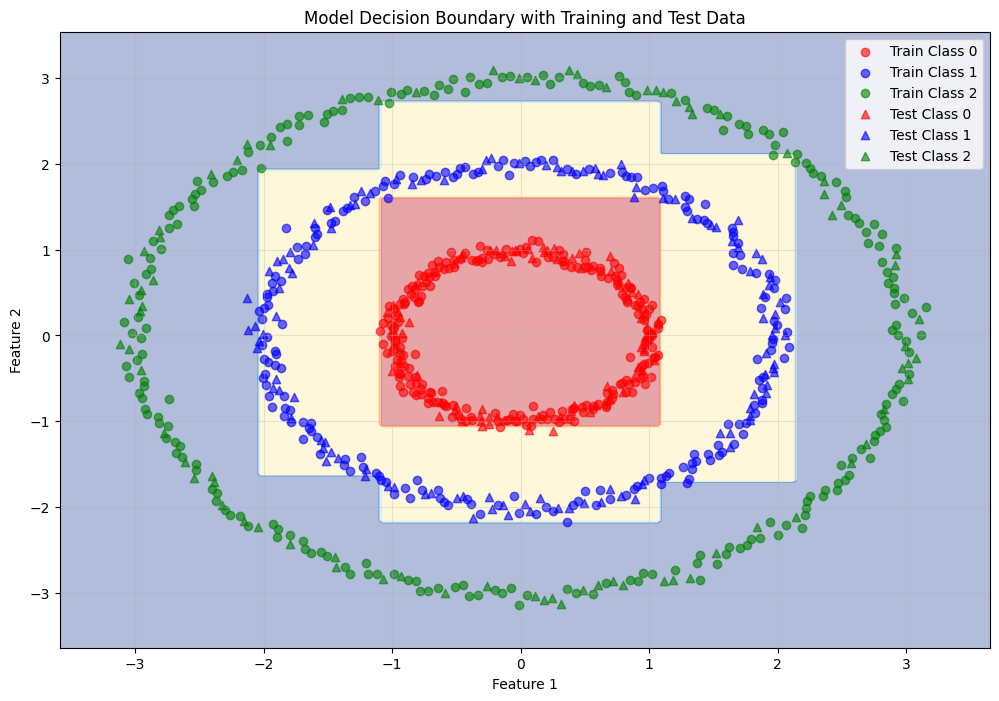

In [38]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(predict(tree, [xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a different colormap for 3 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Plot training data for all three classes
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='red', marker='o', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='blue', marker='o', label='Train Class 1', alpha=0.6)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1],
            c='green', marker='o', label='Train Class 2', alpha=0.6)

# Plot testing data for all three classes
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1],
            c='red', marker='^', label='Test Class 0', alpha=0.6)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1],
            c='blue', marker='^', label='Test Class 1', alpha=0.6)
plt.scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1],
            c='green', marker='^', label='Test Class 2', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [39]:
forest = RandomForest()
forest.fit(X_train.T, y_train)

Train Accuracy:  0.987
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       217
         1.0       0.97      0.98      0.98       189
         2.0       0.99      0.99      0.99       224

    accuracy                           0.99       630
   macro avg       0.99      0.99      0.99       630
weighted avg       0.99      0.99      0.99       630



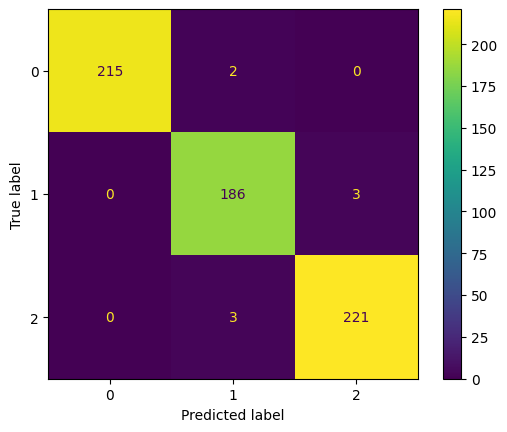

In [40]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(forest.predict(x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.956
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98        83
         1.0       0.96      0.93      0.94       111
         2.0       0.91      0.97      0.94        76

    accuracy                           0.96       270
   macro avg       0.95      0.96      0.96       270
weighted avg       0.96      0.96      0.96       270



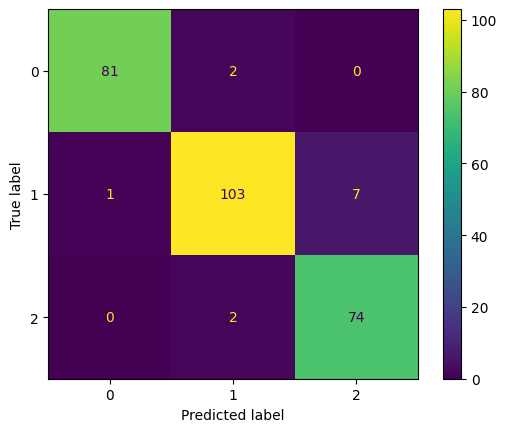

In [41]:
y_pred = []

for x in X_test:
    y_pred.append(forest.predict(x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

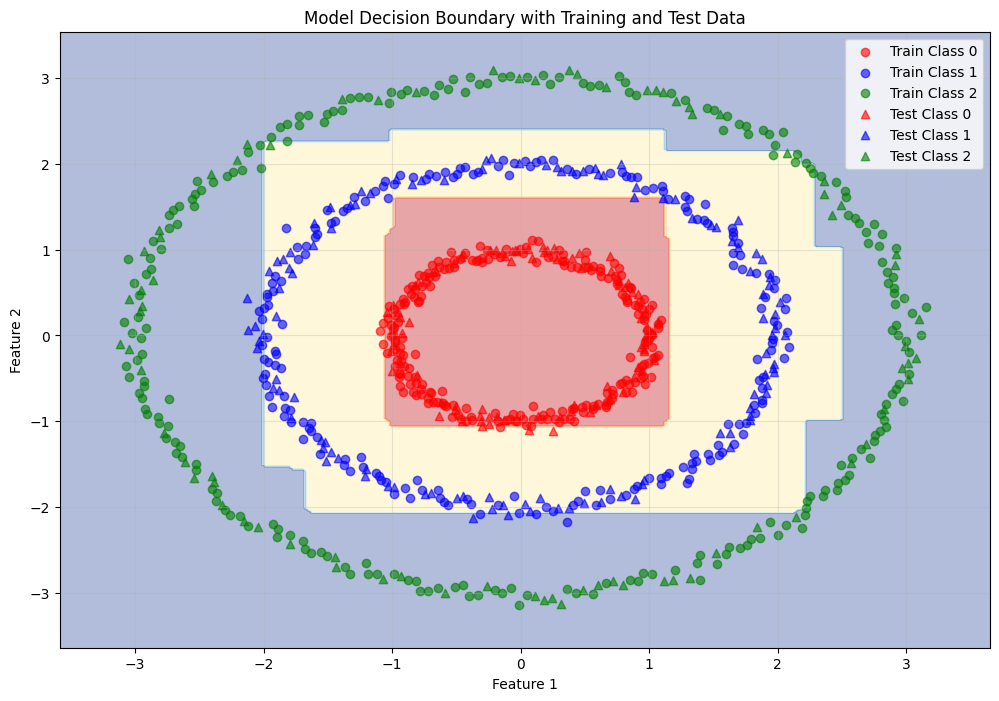

In [42]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(forest.predict([xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a different colormap for 3 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Plot training data for all three classes
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='red', marker='o', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='blue', marker='o', label='Train Class 1', alpha=0.6)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1],
            c='green', marker='o', label='Train Class 2', alpha=0.6)

# Plot testing data for all three classes
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1],
            c='red', marker='^', label='Test Class 0', alpha=0.6)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1],
            c='blue', marker='^', label='Test Class 1', alpha=0.6)
plt.scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1],
            c='green', marker='^', label='Test Class 2', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Spiral Dataset

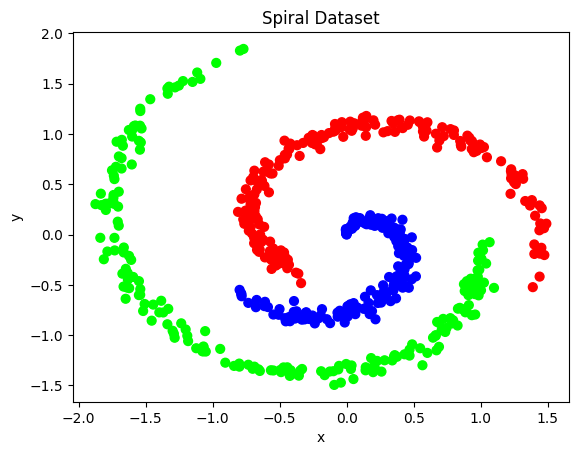

In [41]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace (0.0,1,N) # radius
    r = r+j*0.5
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta

    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

spiral4= np.column_stack ((X,y))
#np.savetxt (" spiral5.csv", spiral4 , delimiter =",", header ="x,y,label", comments="", fmt='%.5f')

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.title('Spiral Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [42]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (600, 2)
y Shape: (600,)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (420, 2)
X_test Shape: (180, 2)
y_train Shape: (420,)
y_test Shape: (180,)


In [44]:
tree = build_tree(X_train.T, y_train, min_samples_split=4, min_info_gain=1e-4)

In [45]:
visualize_tree(tree)

Node: Feature 1, Threshold -0.39, Info Gain 0.3266
  Node: Feature 1, Threshold -0.87, Info Gain 0.4316
    Leaf: Probabilities {2: 1.0}
    Node: Feature 0, Threshold 0.68, Info Gain 0.4569
      Node: Feature 0, Threshold -0.80, Info Gain 0.6116
        Leaf: Probabilities {2: 1.0}
        Leaf: Probabilities {0: 1.0}
      Node: Feature 0, Threshold 1.39, Info Gain 0.2762
        Leaf: Probabilities {2: 1.0}
        Leaf: Probabilities {1: 1.0}
  Node: Feature 0, Threshold -0.78, Info Gain 0.4843
    Leaf: Probabilities {2: 1.0}
    Node: Feature 1, Threshold 0.24, Info Gain 0.3781
      Node: Feature 0, Threshold -0.00, Info Gain 0.5728
        Leaf: Probabilities {1: 1.0}
        Node: Feature 0, Threshold 0.98, Info Gain 0.7173
          Leaf: Probabilities {0: 1.0}
          Node: Feature 0, Threshold 1.40, Info Gain 0.9367
            Leaf: Probabilities {2: 1.0}
            Leaf: Probabilities {1: 1.0}
      Node: Feature 1, Threshold 1.85, Info Gain 0.0808
        Leaf: Proba

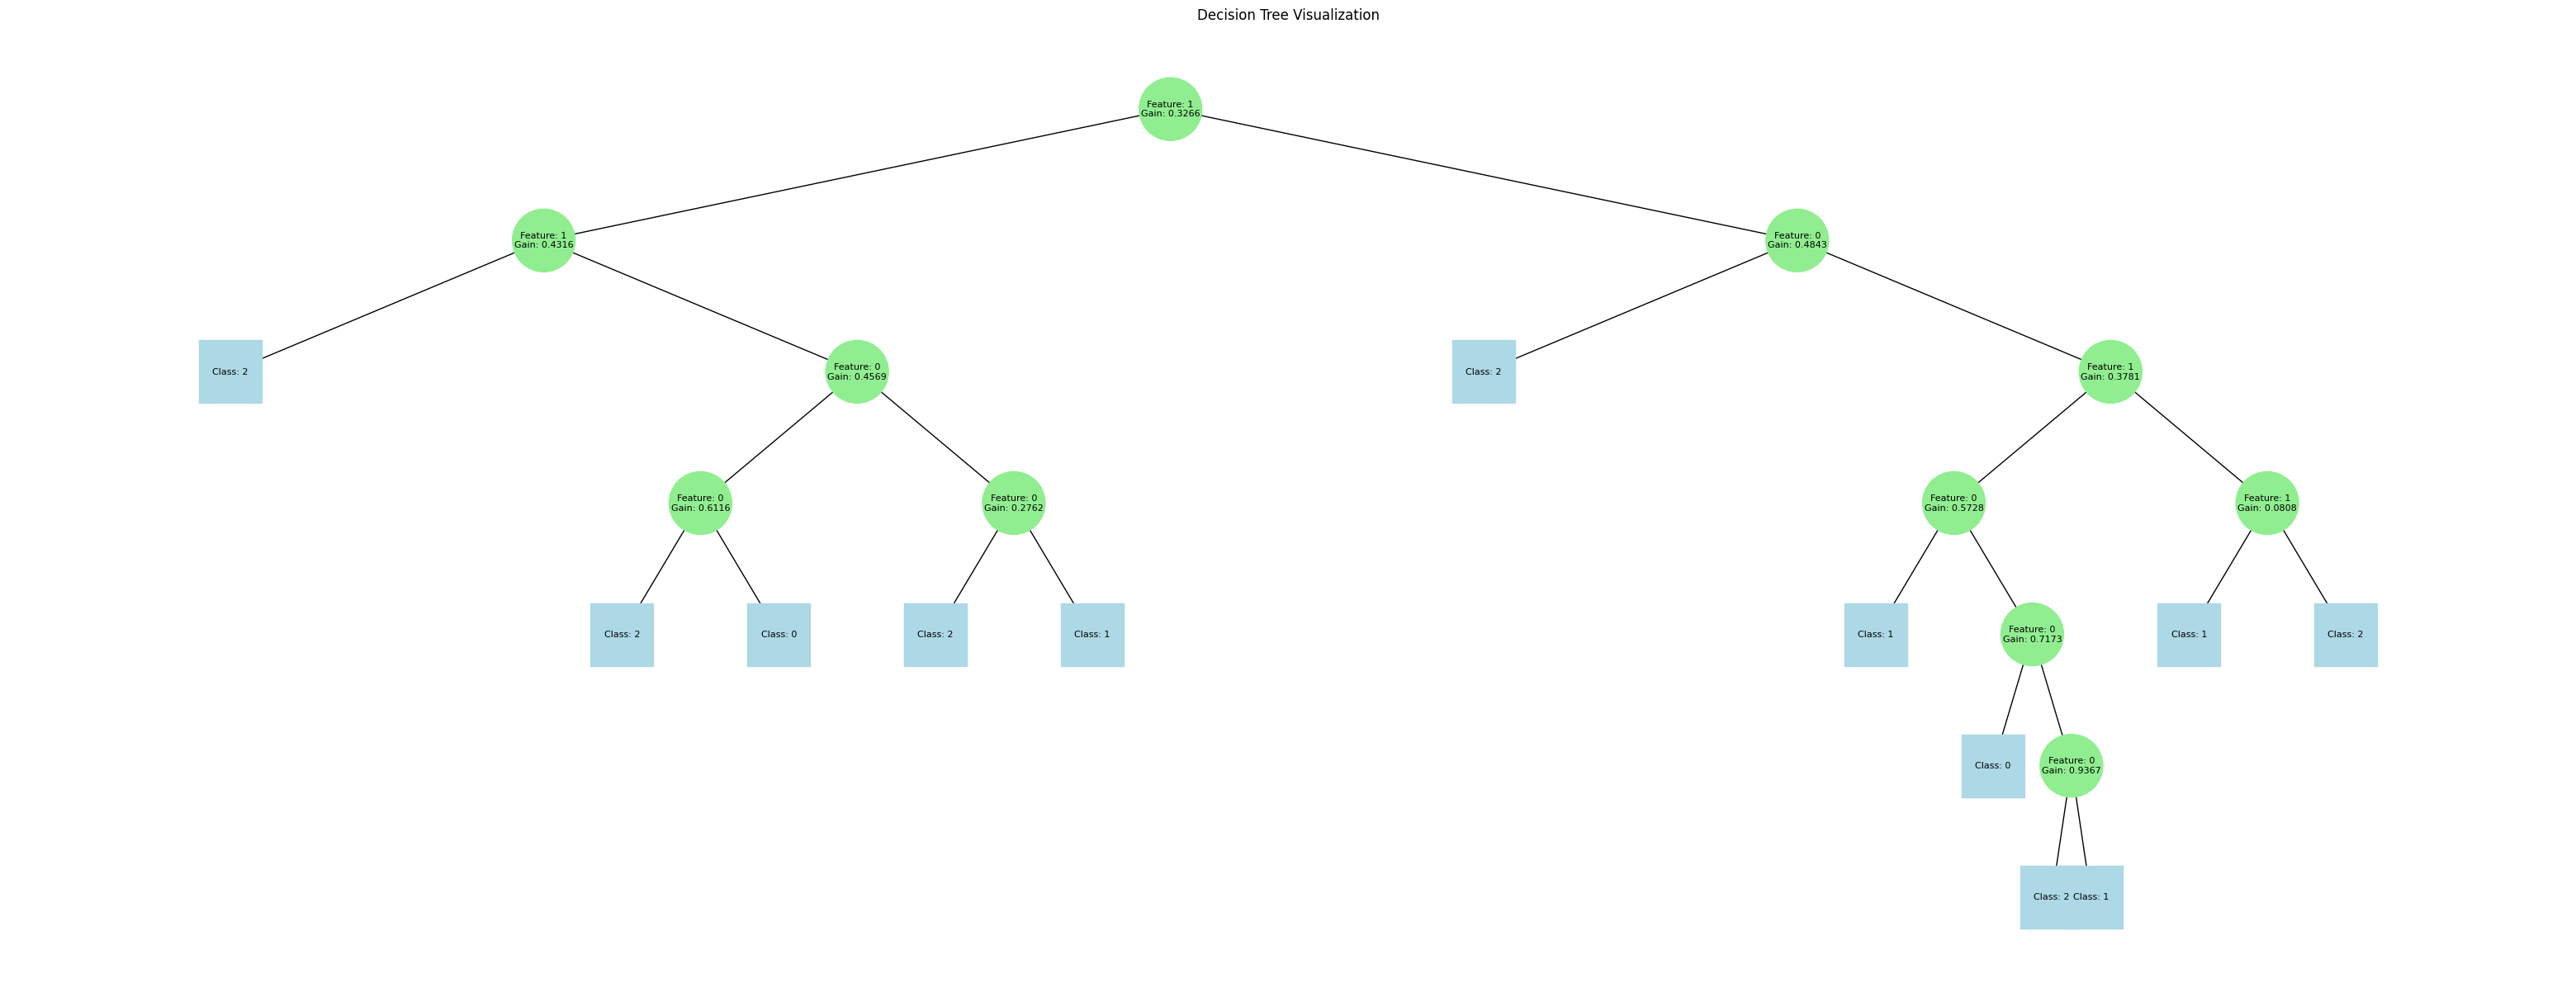

In [48]:
plt.figure(figsize=(40, 15))
plot_decision_tree(tree)

Train Accuracy:  1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       142

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



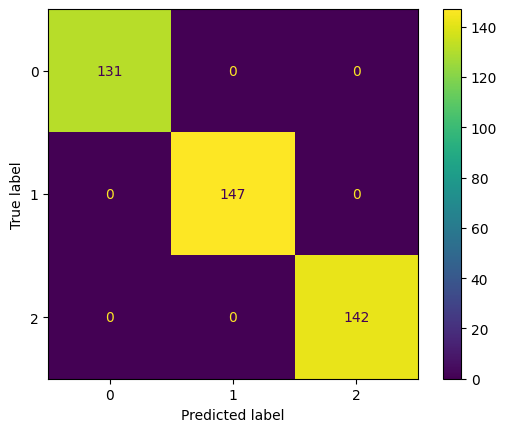

In [48]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(predict(tree, x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.989
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        69
           1       1.00      0.98      0.99        53
           2       0.97      1.00      0.98        58

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



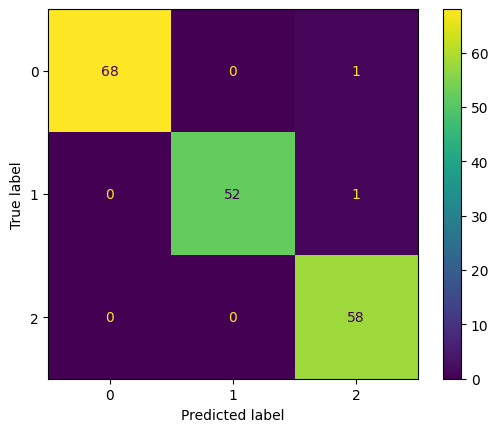

In [49]:
y_pred = []

for x in X_test:
    y_pred.append(predict(tree, x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

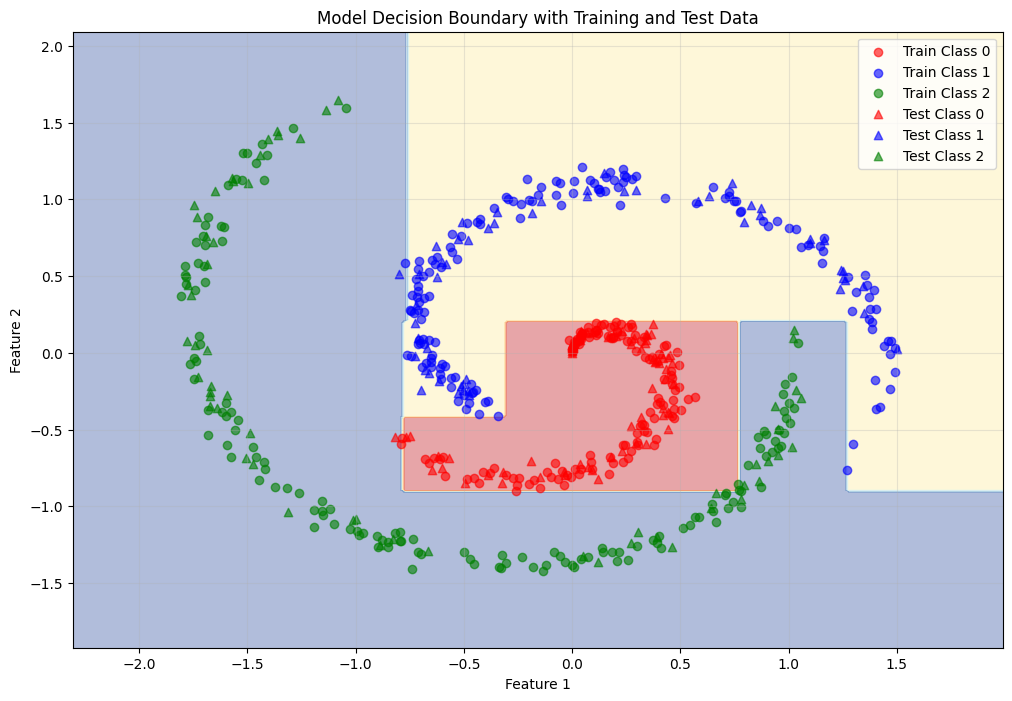

In [50]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(predict(tree, [xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a different colormap for 3 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Plot training data for all three classes
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='red', marker='o', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='blue', marker='o', label='Train Class 1', alpha=0.6)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1],
            c='green', marker='o', label='Train Class 2', alpha=0.6)

# Plot testing data for all three classes
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1],
            c='red', marker='^', label='Test Class 0', alpha=0.6)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1],
            c='blue', marker='^', label='Test Class 1', alpha=0.6)
plt.scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1],
            c='green', marker='^', label='Test Class 2', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [51]:
forest = RandomForest()
forest.fit(X_train.T, y_train)

Train Accuracy:  0.981
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       131
           1       1.00      0.97      0.99       147
           2       0.97      0.99      0.98       142

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420



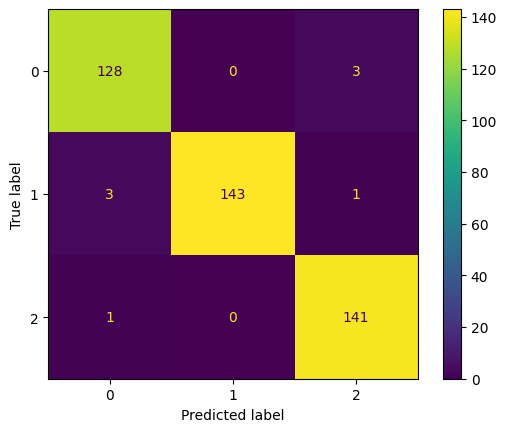

In [52]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(forest.predict(x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.978
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        69
           1       1.00      0.98      0.99        53
           2       0.94      1.00      0.97        58

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



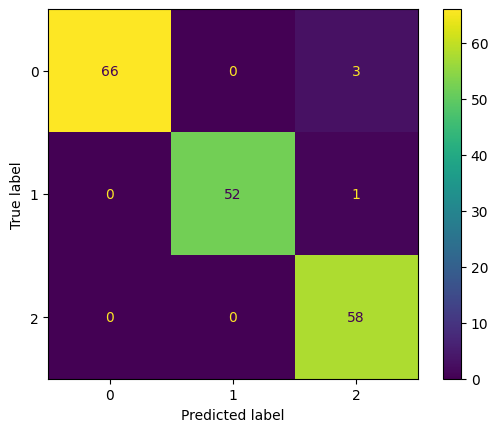

In [53]:
y_pred = []

for x in X_test:
    y_pred.append(forest.predict(x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

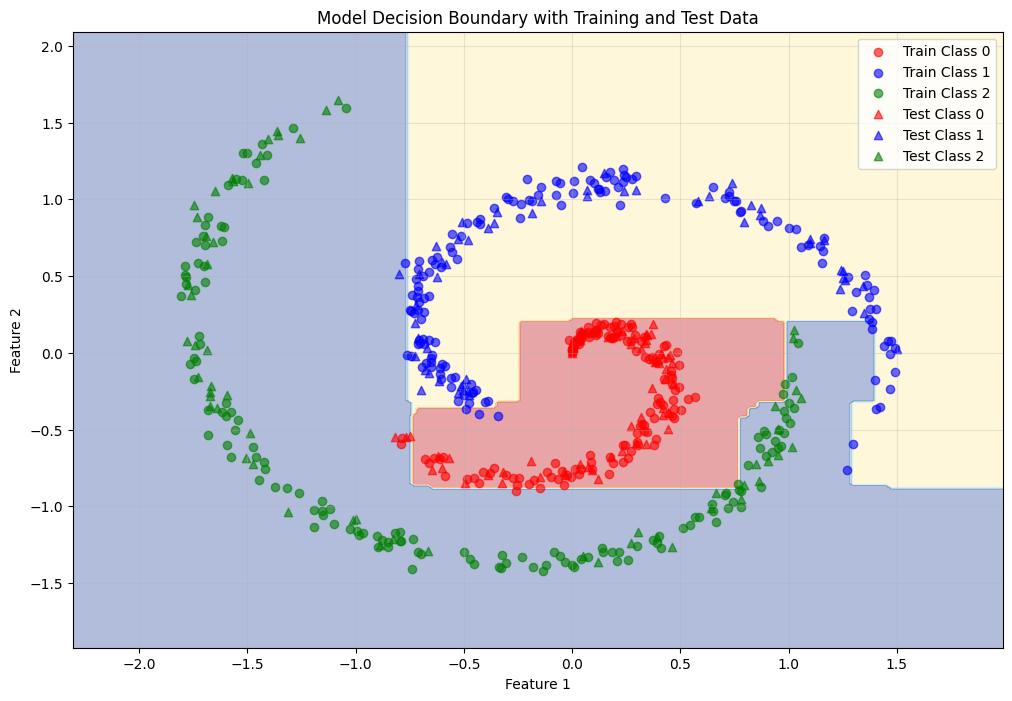

In [54]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(forest.predict([xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a different colormap for 3 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Plot training data for all three classes
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='red', marker='o', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='blue', marker='o', label='Train Class 1', alpha=0.6)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1],
            c='green', marker='o', label='Train Class 2', alpha=0.6)

# Plot testing data for all three classes
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1],
            c='red', marker='^', label='Test Class 0', alpha=0.6)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1],
            c='blue', marker='^', label='Test Class 1', alpha=0.6)
plt.scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1],
            c='green', marker='^', label='Test Class 2', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Balanced Spiral Dataset

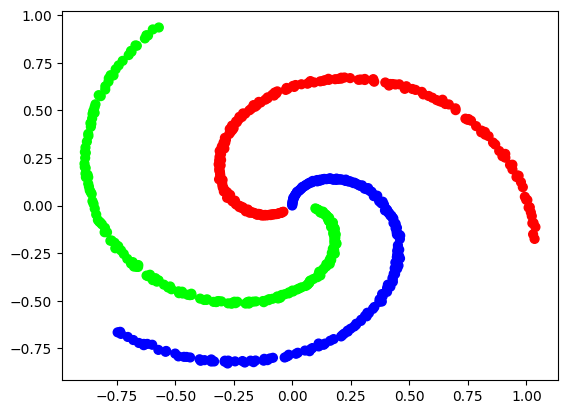

In [49]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace (0.0,1,N) # radius
    r = r+j*0.05
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.02 # theta

    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

spiral5= np.column_stack ((X,y))

#np.savetxt("spiral3u.csv", spiral5 , delimiter=",", header="x,y,label", comments="", fmt='%.5f')

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

In [50]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (600, 2)
y Shape: (600,)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (420, 2)
X_test Shape: (180, 2)
y_train Shape: (420,)
y_test Shape: (180,)


In [52]:
tree = build_tree(X_train.T, y_train, min_samples_split=4, min_info_gain=1e-4)

In [53]:
visualize_tree(tree)

Node: Feature 1, Threshold -0.11, Info Gain 0.3225
  Node: Feature 1, Threshold -0.52, Info Gain 0.4459
    Leaf: Probabilities {0: 1.0}
    Node: Feature 0, Threshold 0.37, Info Gain 0.7905
      Leaf: Probabilities {2: 1.0}
      Node: Feature 0, Threshold 1.03, Info Gain 0.2223
        Leaf: Probabilities {0: 1.0}
        Leaf: Probabilities {1: 1.0}
  Node: Feature 0, Threshold -0.31, Info Gain 0.4072
    Leaf: Probabilities {2: 1.0}
    Node: Feature 1, Threshold 0.15, Info Gain 0.3382
      Node: Feature 0, Threshold 0.00, Info Gain 0.5957
        Leaf: Probabilities {1: 1.0}
        Node: Feature 0, Threshold 0.98, Info Gain 0.5961
          Node: Feature 1, Threshold -0.02, Info Gain 0.6422
            Node: Feature 0, Threshold 0.42, Info Gain 0.5033
              Leaf: Probabilities {2: 1.0}
              Leaf: Probabilities {0: 1.0}
            Leaf: Probabilities {0: 1.0}
          Leaf: Probabilities {1: 1.0}
      Leaf: Probabilities {1: 1.0}


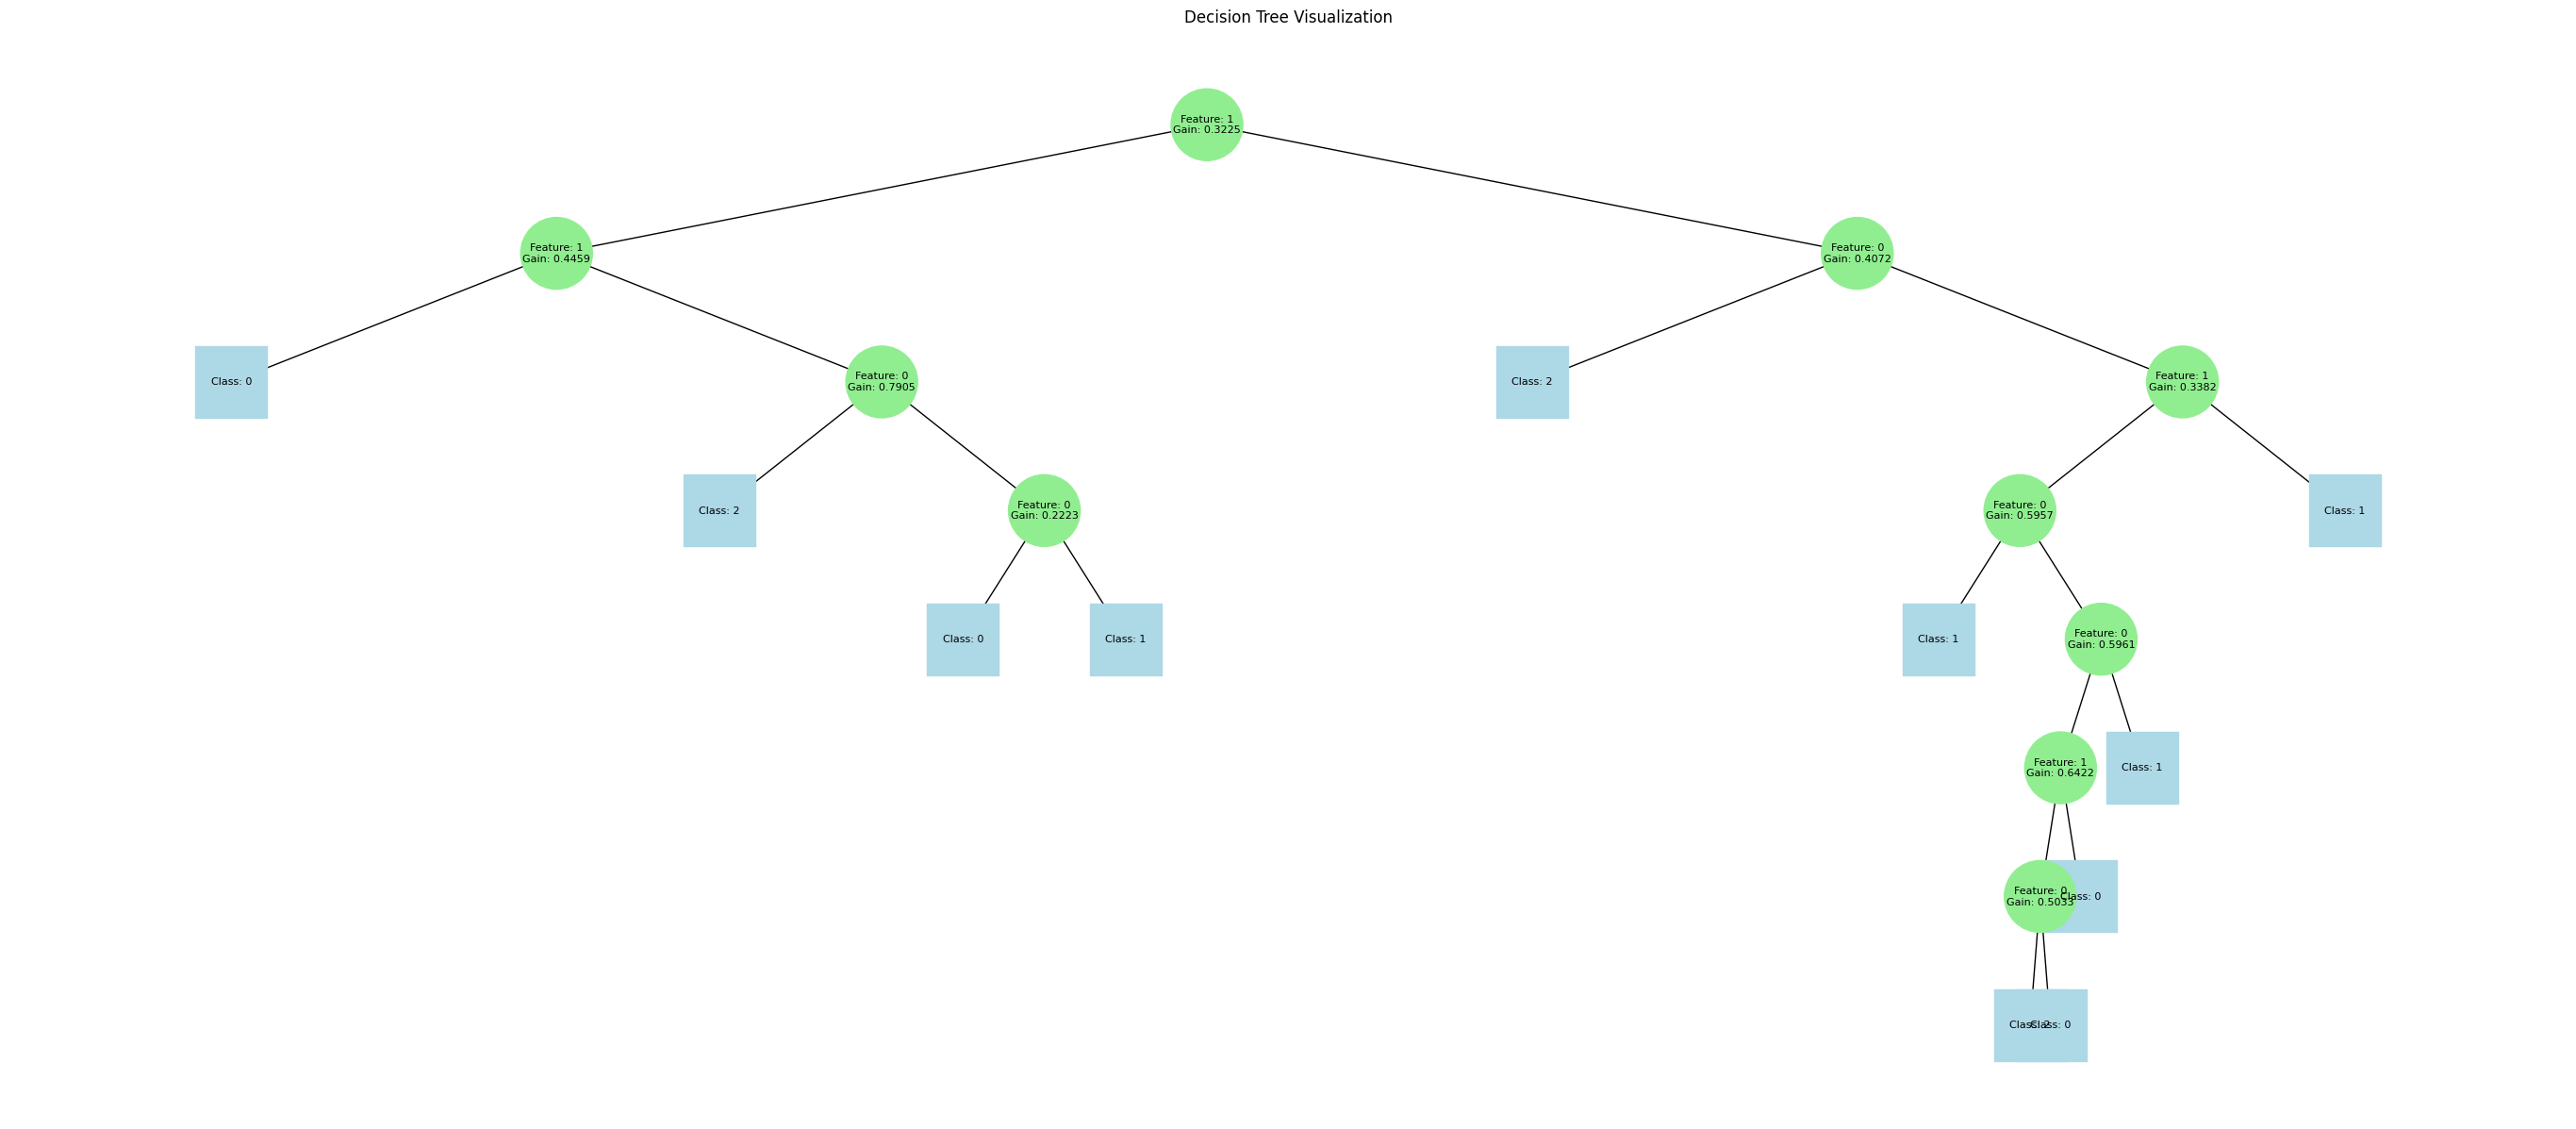

In [58]:
plt.figure(figsize=(35, 15))
plot_decision_tree(tree)

Train Accuracy:  1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       142

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



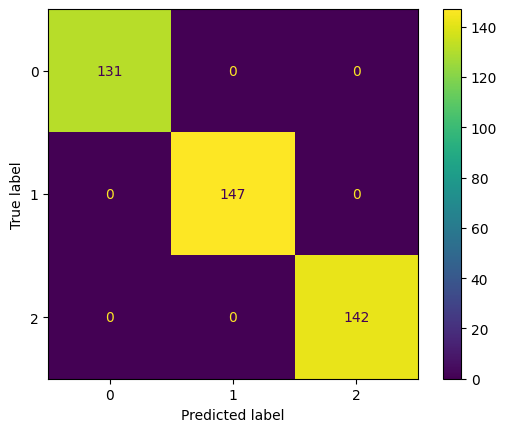

In [60]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(predict(tree, x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.989
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        69
           1       0.98      1.00      0.99        53
           2       0.98      1.00      0.99        58

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



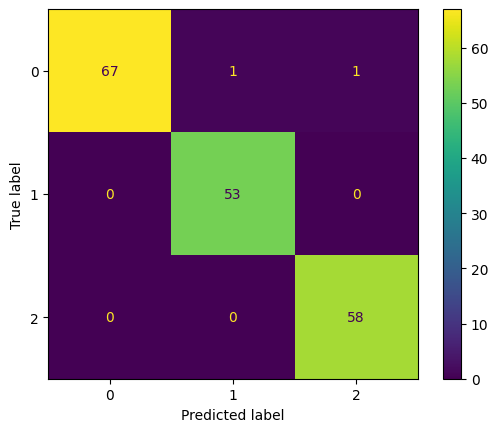

In [61]:
y_pred = []

for x in X_test:
    y_pred.append(predict(tree, x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

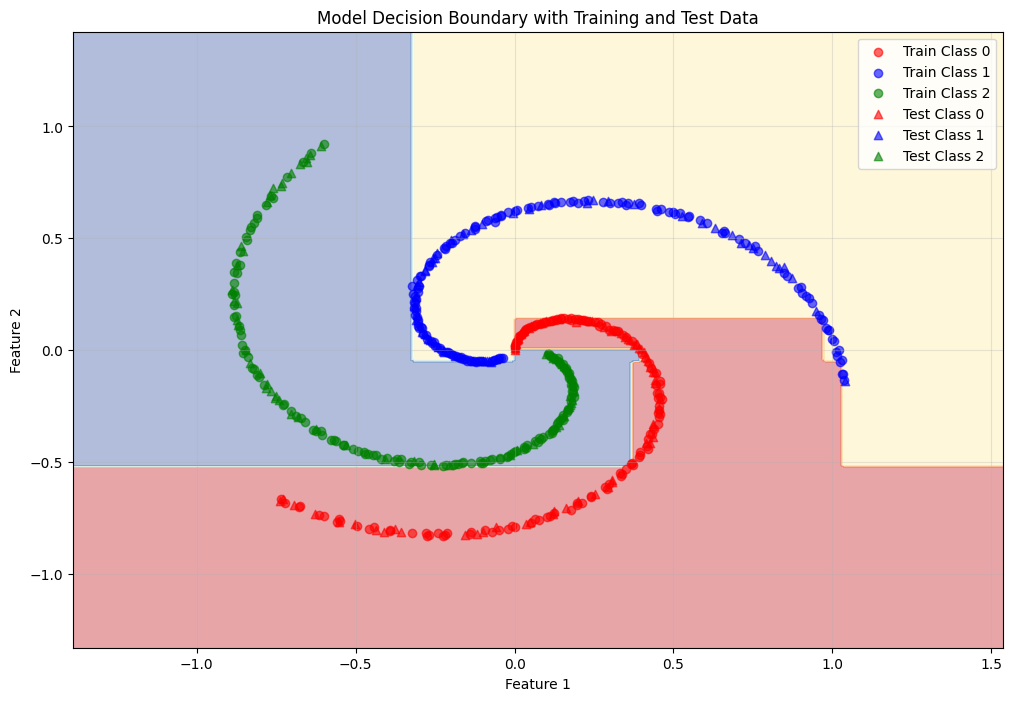

In [62]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(predict(tree, [xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a different colormap for 3 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Plot training data for all three classes
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='red', marker='o', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='blue', marker='o', label='Train Class 1', alpha=0.6)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1],
            c='green', marker='o', label='Train Class 2', alpha=0.6)

# Plot testing data for all three classes
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1],
            c='red', marker='^', label='Test Class 0', alpha=0.6)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1],
            c='blue', marker='^', label='Test Class 1', alpha=0.6)
plt.scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1],
            c='green', marker='^', label='Test Class 2', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [63]:
forest = RandomForest()
forest.fit(X_train.T, y_train)

Train Accuracy:  0.983
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       131
           1       1.00      0.97      0.98       147
           2       0.99      0.99      0.99       142

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420



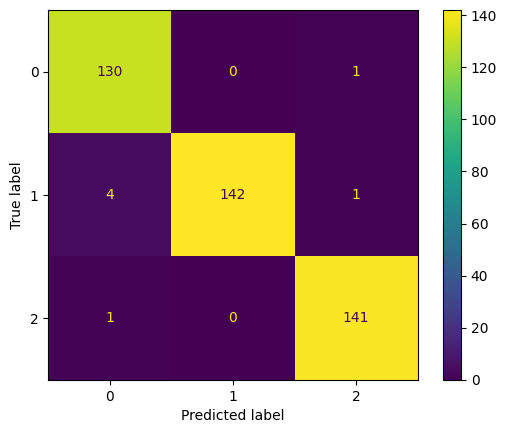

In [64]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(forest.predict(x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.983
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        69
           1       0.98      0.98      0.98        53
           2       0.98      1.00      0.99        58

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



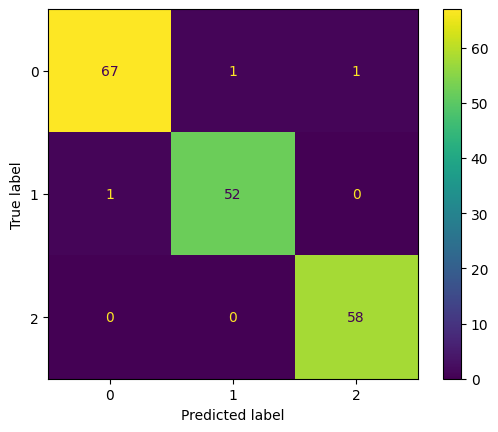

In [65]:
y_pred = []

for x in X_test:
    y_pred.append(forest.predict(x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

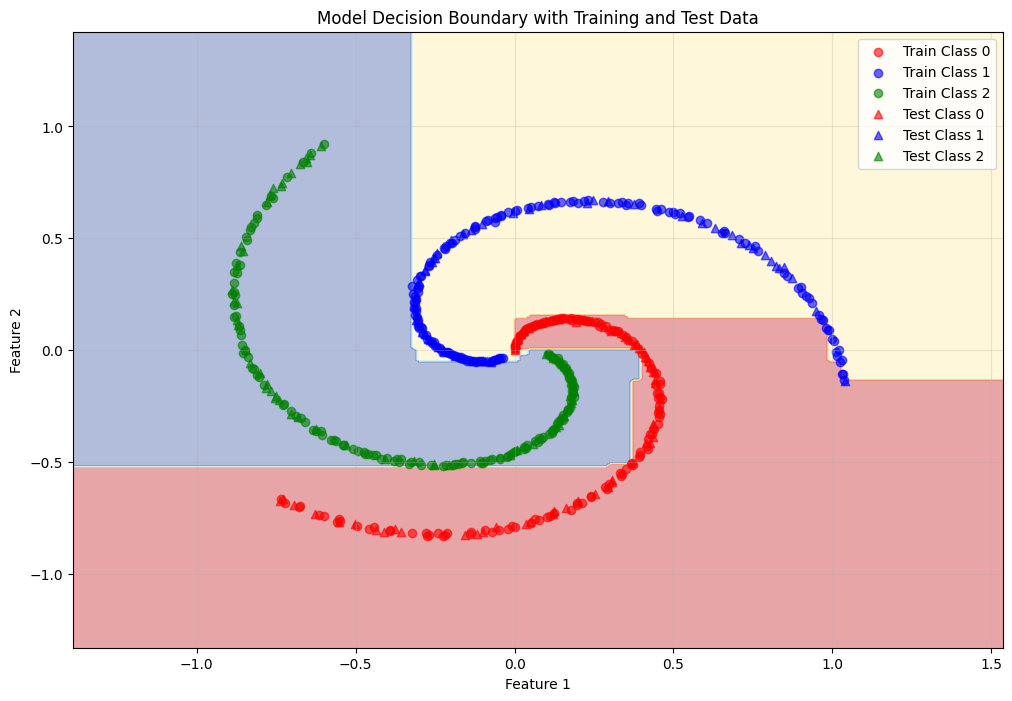

In [66]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(forest.predict([xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a different colormap for 3 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Plot training data for all three classes
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='red', marker='o', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='blue', marker='o', label='Train Class 1', alpha=0.6)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1],
            c='green', marker='o', label='Train Class 2', alpha=0.6)

# Plot testing data for all three classes
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1],
            c='red', marker='^', label='Test Class 0', alpha=0.6)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1],
            c='blue', marker='^', label='Test Class 1', alpha=0.6)
plt.scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1],
            c='green', marker='^', label='Test Class 2', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Five Class Unbalanced Spiral Dataset

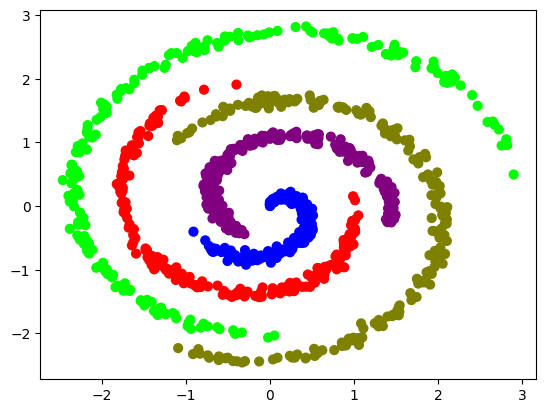

In [59]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace (0.0,1,N) # radius
    r = r+j*0.5
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

spiral4= np.column_stack ((X,y))
#np.savetxt (" spiral5.csv", spiral4 , delimiter =",", header ="x,y,label", comments="", fmt='%.5f')
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

In [60]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (1000, 2)
y Shape: (1000,)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (700, 2)
X_test Shape: (300, 2)
y_train Shape: (700,)
y_test Shape: (300,)


In [62]:
tree = build_tree(X_train.T, y_train, min_samples_split=4, min_info_gain=1e-4)

In [63]:
visualize_tree(tree)

Node: Feature 0, Threshold -0.85, Info Gain 0.3138
  Node: Feature 0, Threshold -1.80, Info Gain 0.3954
    Leaf: Probabilities {4: 1.0}
    Node: Feature 1, Threshold -1.28, Info Gain 0.3506
      Leaf: Probabilities {4: 1.0}
      Node: Feature 1, Threshold 1.81, Info Gain 0.6594
        Node: Feature 0, Threshold -1.10, Info Gain 0.1607
          Leaf: Probabilities {2: 1.0}
          Node: Feature 1, Threshold 1.06, Info Gain 0.4591
            Leaf: Probabilities {2: 1.0}
            Node: Feature 1, Threshold 1.65, Info Gain 0.9183
              Leaf: Probabilities {3: 1.0}
              Leaf: Probabilities {2: 1.0}
        Leaf: Probabilities {4: 1.0}
  Node: Feature 1, Threshold 0.20, Info Gain 0.4043
    Node: Feature 1, Threshold -0.89, Info Gain 0.5243
      Node: Feature 1, Threshold -1.43, Info Gain 0.6620
        Node: Feature 0, Threshold 0.09, Info Gain 0.2231
          Node: Feature 1, Threshold -2.07, Info Gain 0.9544
            Leaf: Probabilities {3: 1.0}
         

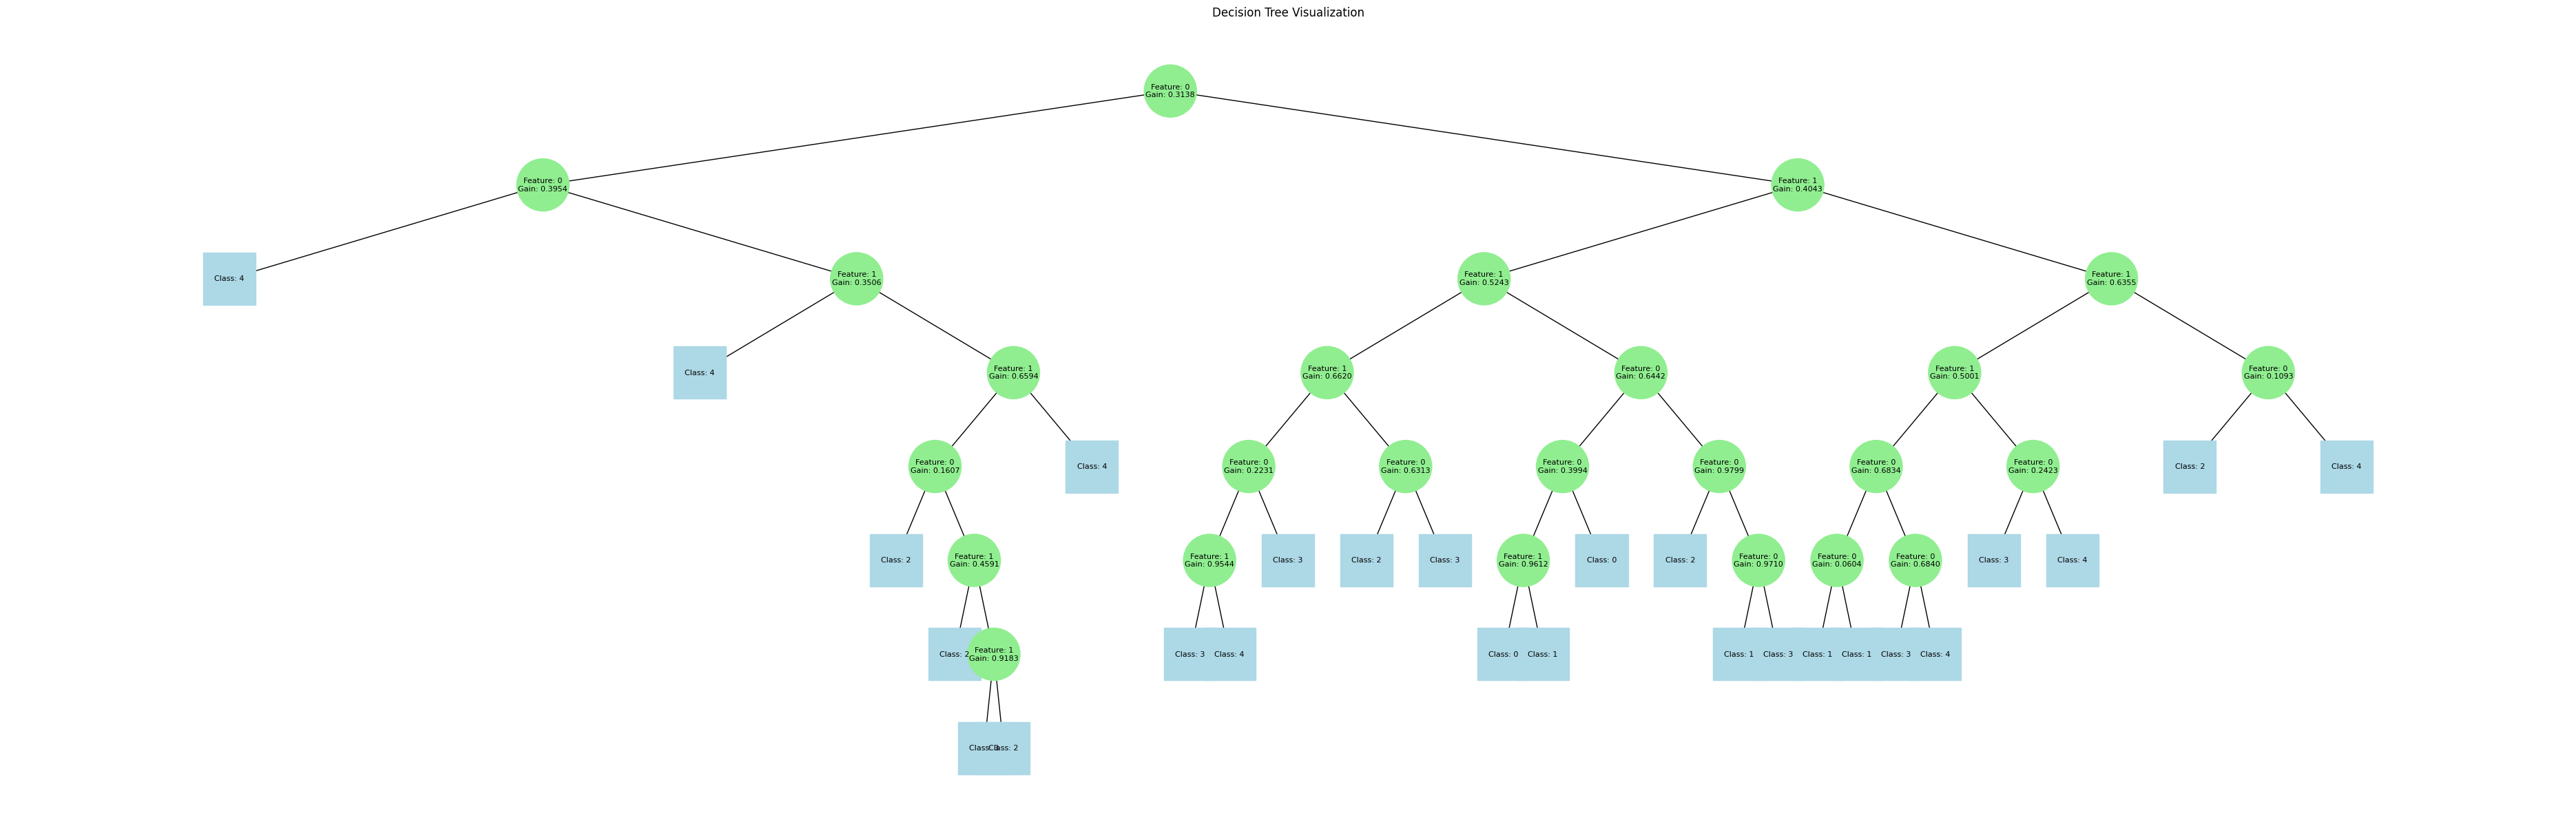

In [67]:
plt.figure(figsize=(48, 15))
plot_decision_tree(tree)

Train Accuracy:  0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       0.99      1.00      1.00       129
           2       0.99      1.00      1.00       143
           3       1.00      0.99      1.00       147
           4       1.00      0.99      1.00       136

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



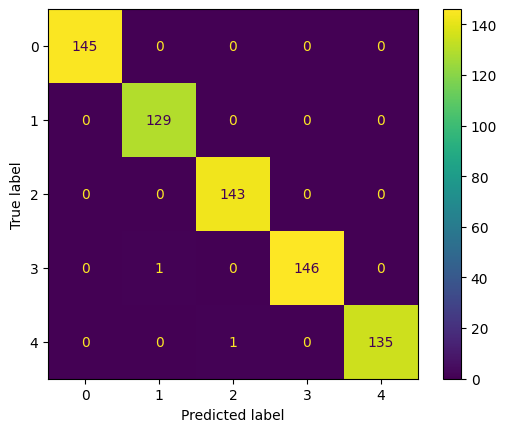

In [64]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(predict(tree, x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.983
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       1.00      0.99      0.99        71
           2       0.98      0.98      0.98        57
           3       0.96      1.00      0.98        53
           4       0.98      0.95      0.97        64

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



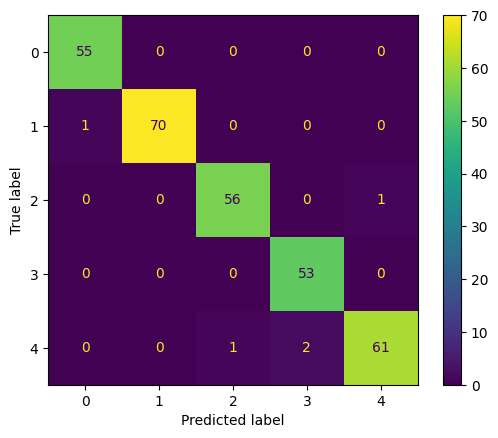

In [33]:
y_pred = []

for x in X_test:
    y_pred.append(predict(tree, x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

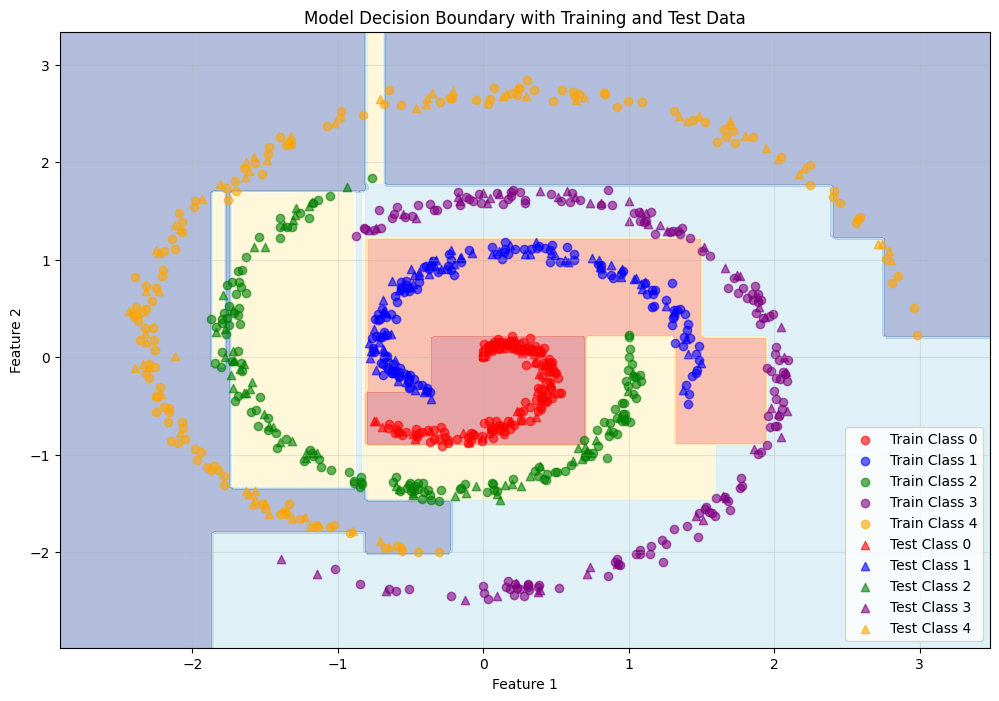

In [39]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(predict(tree, [xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a colormap for 5 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Colors for the classes
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', '^']

# Plot training data for all five classes
for i in range(5):
    plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1],
                c=colors[i], marker='o', label=f'Train Class {i}', alpha=0.6)

# Plot testing data for all five classes
for i in range(5):
    plt.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1],
                c=colors[i], marker='^', label=f'Test Class {i}', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [35]:
forest = RandomForest()
forest.fit(X_train.T, y_train)

Train Accuracy:  0.954
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       145
           1       0.95      0.98      0.97       129
           2       0.93      0.95      0.94       143
           3       0.96      0.95      0.95       147
           4       0.96      0.91      0.94       136

    accuracy                           0.95       700
   macro avg       0.95      0.95      0.95       700
weighted avg       0.95      0.95      0.95       700



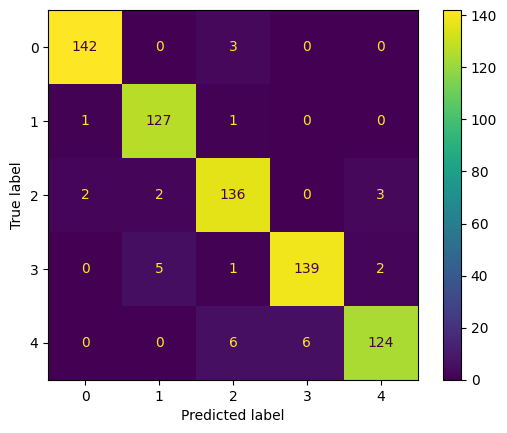

In [36]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(forest.predict(x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.950
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        55
           1       0.97      0.97      0.97        71
           2       0.97      0.98      0.97        57
           3       0.89      0.92      0.91        53
           4       0.97      0.88      0.92        64

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



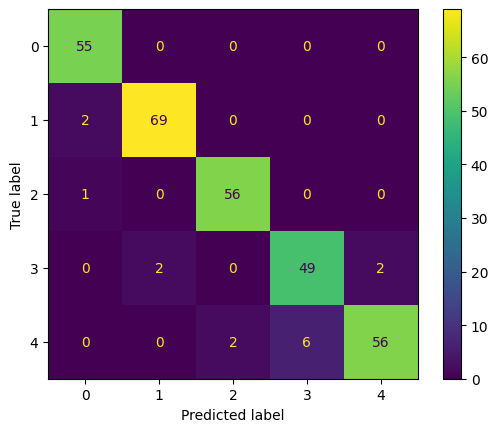

In [37]:
y_pred = []

for x in X_test:
    y_pred.append(forest.predict(x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

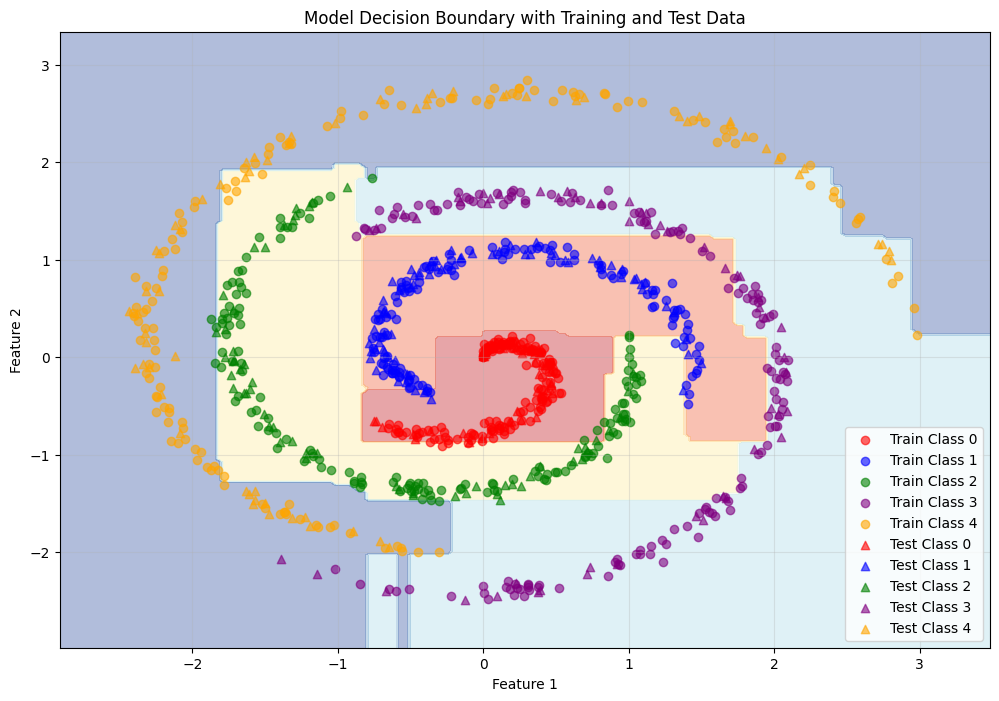

In [38]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(forest.predict([xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a colormap for 5 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Colors for the classes
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', '^']

# Plot training data for all five classes
for i in range(5):
    plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1],
                c=colors[i], marker='o', label=f'Train Class {i}', alpha=0.6)

# Plot testing data for all five classes
for i in range(5):
    plt.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1],
                c=colors[i], marker='^', label=f'Test Class {i}', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Five class Balanced Spiral Dataset

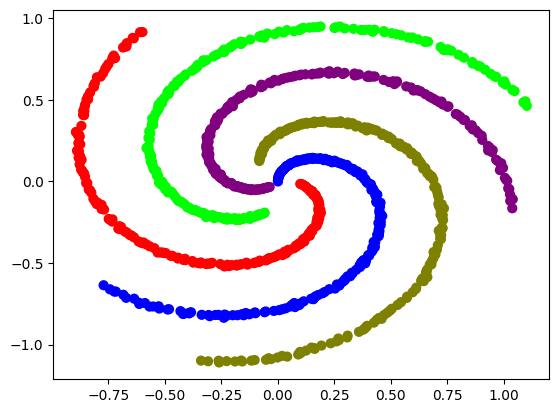

In [68]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes

X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace (0.0,1,N) # radius
    r = r+j*0.05

    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.02 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

spiral5= np.column_stack ((X,y))
#np.savetxt (" spiral5u.csv", spiral5 , delimiter =",", header ="x,y,label",comments ="", fmt='%.5f')
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

In [69]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (1000, 2)
y Shape: (1000,)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (800, 2)
X_test Shape: (200, 2)
y_train Shape: (800,)
y_test Shape: (200,)


In [71]:
tree = build_tree(X_train.T, y_train, min_samples_split=4, min_info_gain=1e-4)

In [72]:
visualize_tree(tree)

Node: Feature 1, Threshold -0.24, Info Gain 0.2594
  Node: Feature 1, Threshold -0.52, Info Gain 0.4675
    Node: Feature 1, Threshold -0.84, Info Gain 0.5147
      Leaf: Probabilities {3: 1.0}
      Node: Feature 0, Threshold 0.47, Info Gain 0.7012
        Leaf: Probabilities {0: 1.0}
        Leaf: Probabilities {3: 1.0}
    Node: Feature 0, Threshold 0.36, Info Gain 0.9095
      Leaf: Probabilities {2: 1.0}
      Node: Feature 0, Threshold 0.67, Info Gain 0.9819
        Leaf: Probabilities {0: 1.0}
        Leaf: Probabilities {3: 1.0}
  Node: Feature 0, Threshold -0.32, Info Gain 0.3289
    Node: Feature 0, Threshold -0.57, Info Gain 0.9837
      Leaf: Probabilities {2: 1.0}
      Leaf: Probabilities {4: 1.0}
    Node: Feature 1, Threshold 0.39, Info Gain 0.3498
      Node: Feature 0, Threshold -0.08, Info Gain 0.5041
        Node: Feature 1, Threshold -0.05, Info Gain 0.8905
          Leaf: Probabilities {4: 1.0}
          Leaf: Probabilities {1: 1.0}
        Node: Feature 1, Thresh

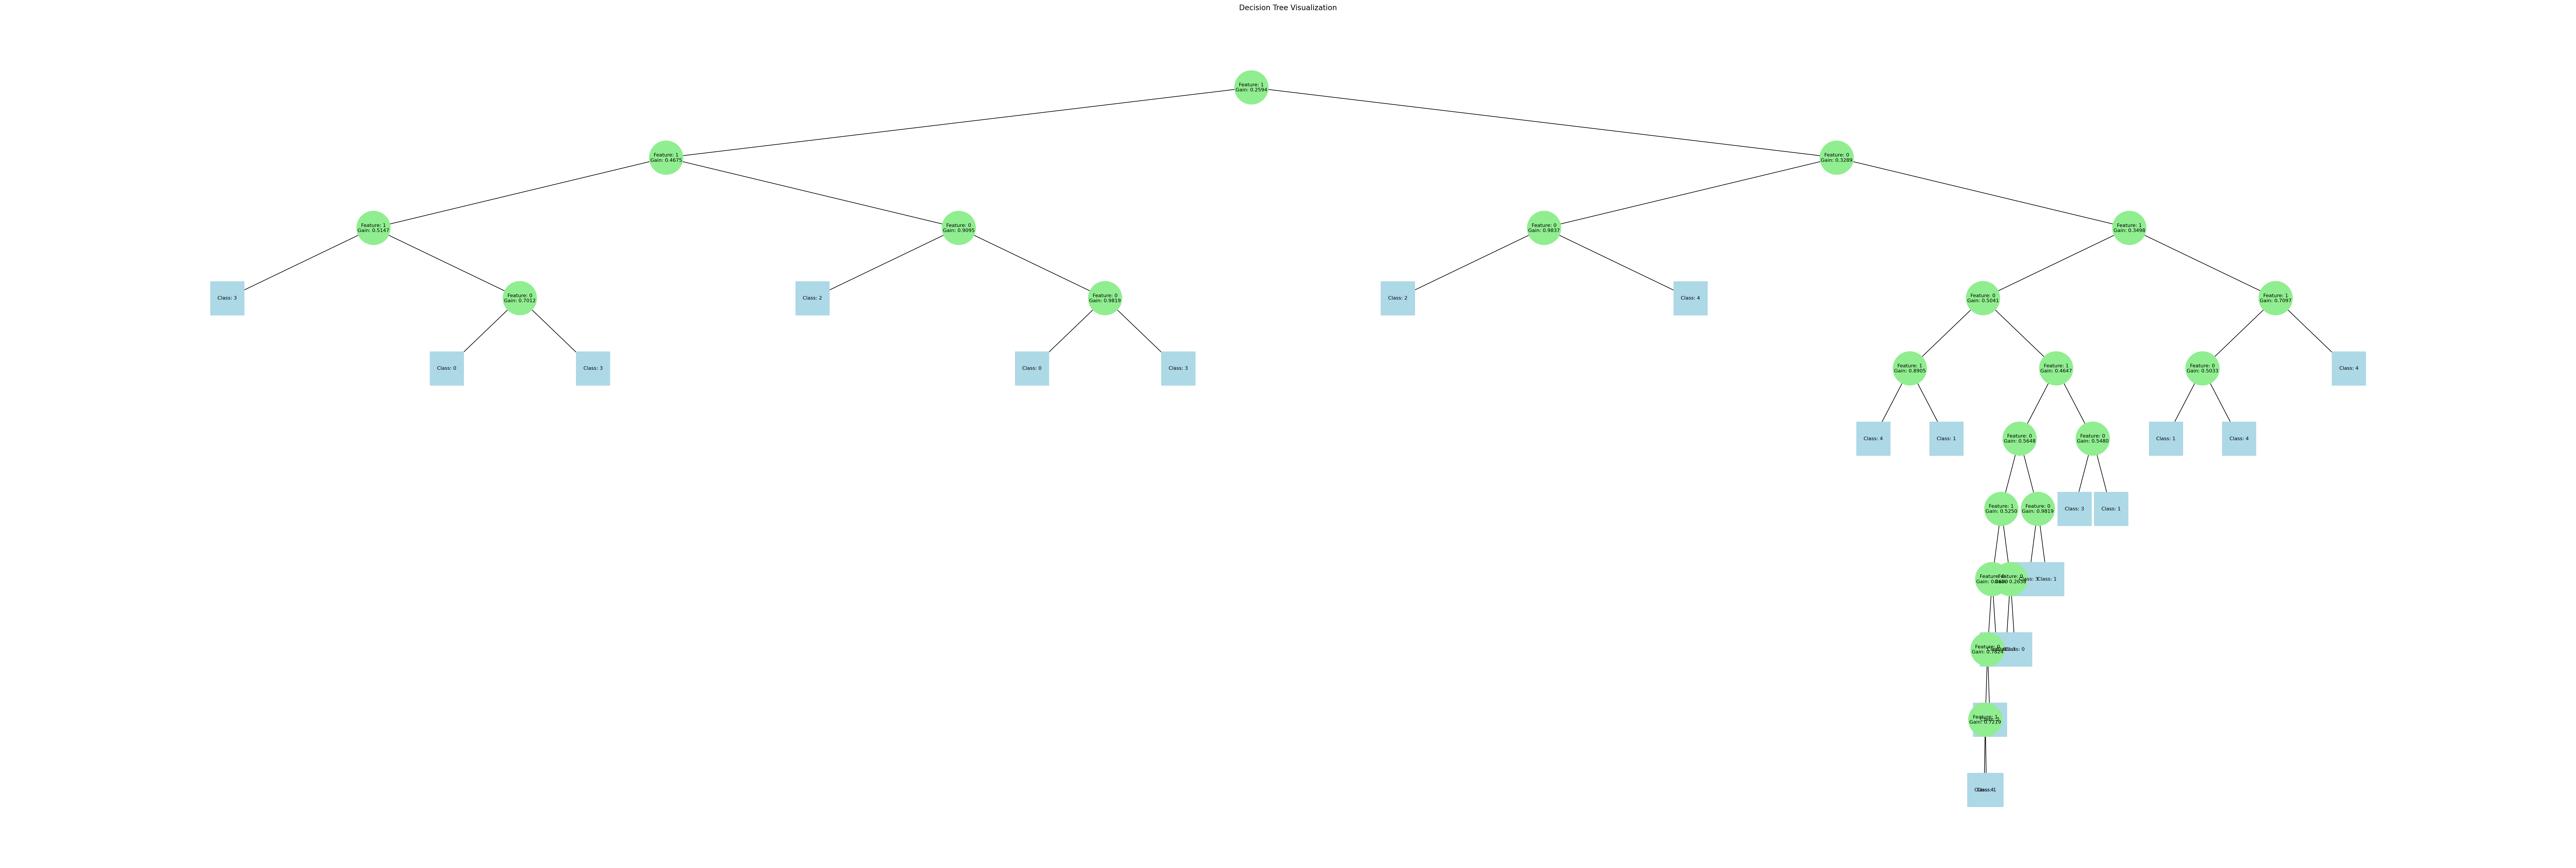

In [79]:
plt.figure(figsize=(75, 25), dpi=200)
plot_decision_tree(tree)

Train Accuracy:  1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00       163
           3       1.00      1.00      1.00       162
           4       1.00      1.00      1.00       156

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



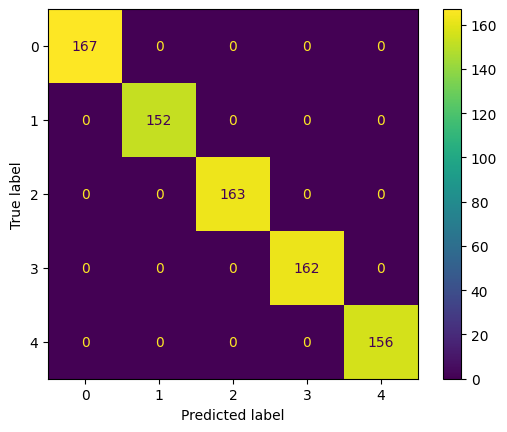

In [89]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(predict(tree, x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.98      0.92      0.95        48
           2       1.00      1.00      1.00        37
           3       0.97      1.00      0.99        38
           4       0.93      0.98      0.96        44

    accuracy                           0.97       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.97      0.97       200



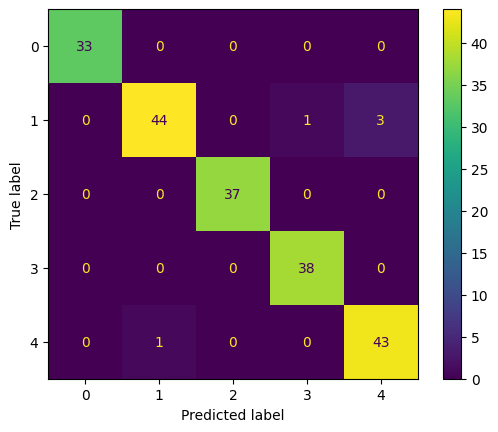

In [90]:
y_pred = []

for x in X_test:
    y_pred.append(predict(tree, x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

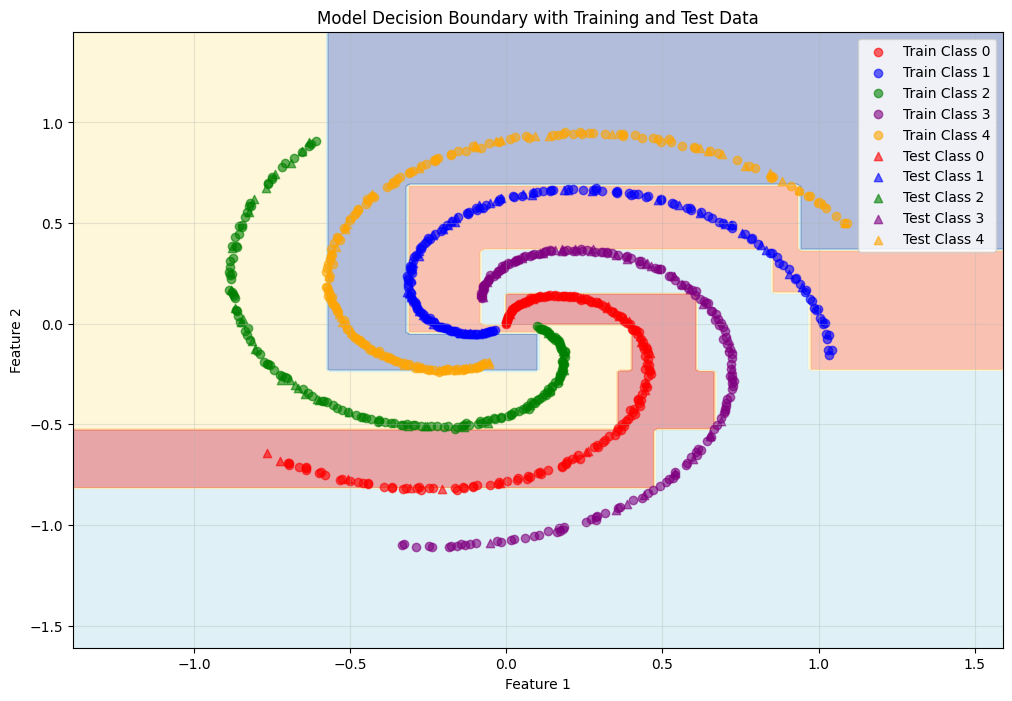

In [91]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(predict(tree, [xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a colormap for 5 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Colors for the classes
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', '^']

# Plot training data for all five classes
for i in range(5):
    plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1],
                c=colors[i], marker='o', label=f'Train Class {i}', alpha=0.6)

# Plot testing data for all five classes
for i in range(5):
    plt.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1],
                c=colors[i], marker='^', label=f'Test Class {i}', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [92]:
forest = RandomForest()
forest.fit(X_train.T, y_train)

Train Accuracy:  0.975
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       167
           1       0.95      0.97      0.96       152
           2       0.98      0.98      0.98       163
           3       0.98      0.97      0.98       162
           4       0.98      0.96      0.97       156

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.98      0.97      0.98       800



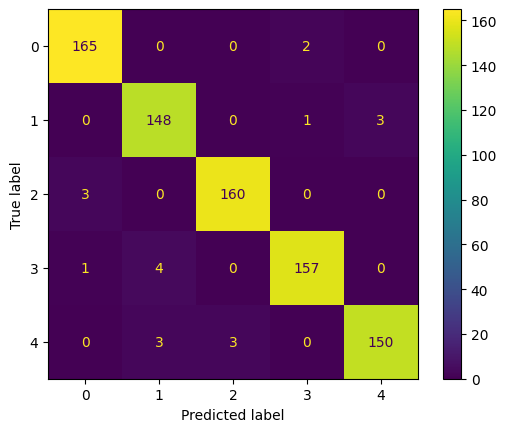

In [93]:
y_pred_train = []

for x in X_train:
    y_pred_train.append(forest.predict(x))

y_pred = np.array(y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy: .3f}")

class_report = classification_report(y_train, y_pred_train)
print(class_report)

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Test Accuracy:  0.950
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.92      0.92      0.92        48
           2       0.97      0.97      0.97        37
           3       0.97      0.95      0.96        38
           4       0.93      0.93      0.93        44

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



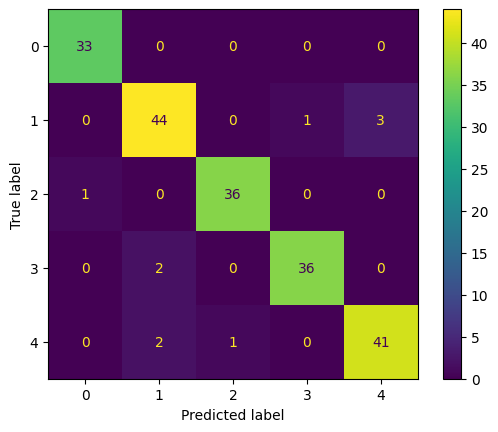

In [94]:
y_pred = []

for x in X_test:
    y_pred.append(forest.predict(x))

y_pred = np.array(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy: .3f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

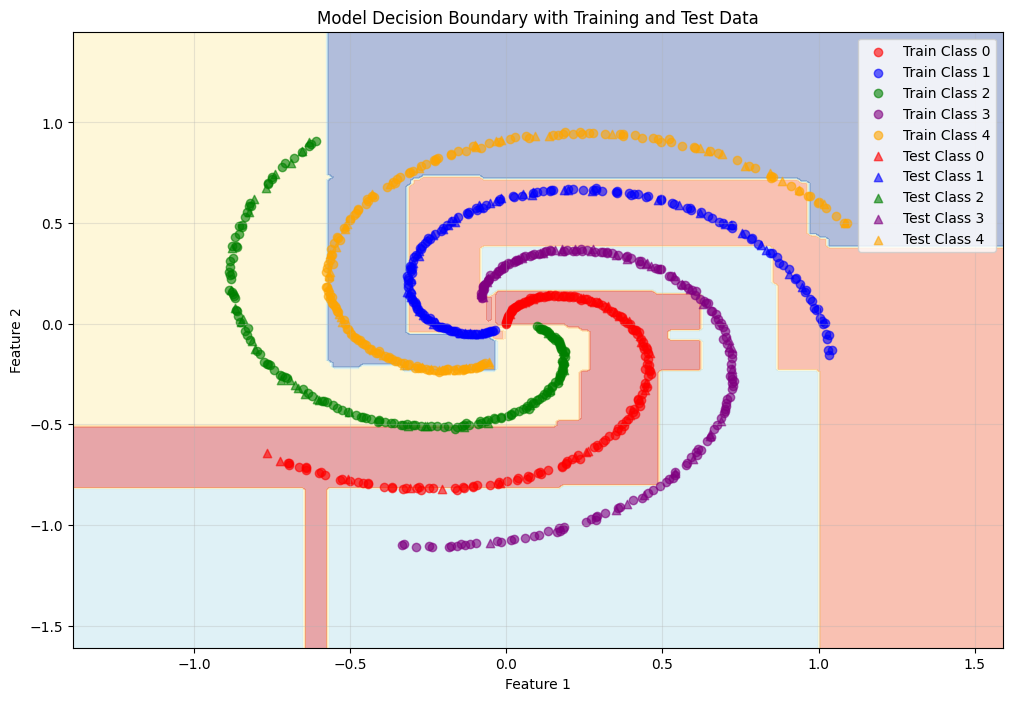

In [95]:
# Create a mesh grid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for each point in the mesh
Z = []
for i in range(len(xx.ravel())):
    Z.append(forest.predict([xx.ravel()[i], yy.ravel()[i]]))
Z = np.array(Z)
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the decision boundary with a colormap for 5 classes
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')

# Colors for the classes
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', '^']

# Plot training data for all five classes
for i in range(5):
    plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1],
                c=colors[i], marker='o', label=f'Train Class {i}', alpha=0.6)

# Plot testing data for all five classes
for i in range(5):
    plt.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1],
                c=colors[i], marker='^', label=f'Test Class {i}', alpha=0.6)

plt.title('Model Decision Boundary with Training and Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()